In [6]:
#!pip install tensorflow
#!pip install scikit-learn
#!pip install matplotlib
#!pip install pandas
#!pip install pyyaml
#!pip install shap
# !pip install keras_sequential_ascii
!pip install nnv


In [7]:
import pandas as pd
pd.set_option('display.max_rows', None)
import yaml
import warnings
warnings.simplefilter("ignore")
#from joblib import load, dump
import argparse
#import shap
import numpy as np
import matplotlib.pyplot as plt
import functools
print = functools.partial(print, flush=True)
from sklearn.preprocessing import label_binarize, MinMaxScaler
from tensorflow import keras
from sklearn.metrics import (
    roc_curve,precision_score,
    precision_recall_curve,roc_auc_score,
     f1_score,accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    confusion_matrix,
    average_precision_score,
    recall_score
)

from sklearn.utils import class_weight
import shap
from keras_sequential_ascii import keras2ascii
from nnv import NNV


In [8]:
warnings.simplefilter("ignore", category=DeprecationWarning)


In [9]:
with open(
        "../../configs/col_config.yaml"
    ) as fh:
        config_dict = yaml.safe_load(fh)

with open(
        "../../configs/var_class.yaml"
    ) as fh1:
        var_dict = yaml.safe_load(fh1)


In [10]:
set(var_dict.values())


{'3 prime UTR',
 '5 prime UTR',
 'NMD',
 'complex substitution',
 'exon loss variant',
 'frameshift elongation',
 'frameshift truncation',
 'inframe deletion',
 'inframe insertion',
 'intergenic',
 'intron',
 'missense',
 'other RNA',
 'splice site',
 'start lost',
 'start retained',
 'stop gained',
 'stop lost',
 'stop retained',
 'synonymous'}

In [11]:
#amis = pd.read_csv("/Users/tarunmamidi/Downloads/AlphaMissense_hg38.tsv", low_memory=False, skiprows=3, sep='\t')
#amis.head()


In [12]:
clf = keras.models.load_model('../../model/Neural_network/')
clf.load_weights("../../model/weights.h5")
clf.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 239)               57360     
                                                                 
 dense_l0 (Dense)            (None, 161)               38640     
                                                                 
 dropout (Dropout)           (None, 161)               0         
                                                                 
 dense_last (Dense)          (None, 1)                 162       
                                                                 
Total params: 96,162
Trainable params: 96,162
Non-trainable params: 0
_________________________________________________________________


In [13]:
#keras2ascii(clf)


In [14]:
# layersList = [
#     {"title":"Input\n(239 n)\n(elu)", "units": 239, "color": "green", "edges_color":"darkBlue", "edges_width":2},
#     {"title":"Dense\n(161 n)\n(elu)", "units": 161, "edges_color":"darkBlue", "edges_width":2,"color": "orange"},
#     #{"title":"Dropout", "units": 161, "edges_color":"red", "edges_width":2},
#     {"title":"output\n(1 n)\n(sigmoid)", "units": 1,"color": "red"},
# ]

# NNV(layersList).render(save_to_file="DITTO.png")


In [5]:
X_train = pd.read_csv(f"../../data/external/train_class_data_80.csv.gz")
X_train.head()

,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,mutationtaster.prediction_Automatic Polymorphism,mutationtaster.prediction_Damaging,mutationtaster.prediction_Polymorphism,mutationtaster.model_complex_aae,mutationtaster.model_simple_aae,mutationtaster.model_without_aae,prec.stat_lof-tolerant,prec.stat_recessive,sift.confidence_High,sift.confidence_Low
0,ENST00000350721,ATR,synonymous_variant,p.Asp2494=,c.7482T>C,chr3,142458979,A,G,NaN,...,0,0,0,0,0,0,0,1,1,0
1,ENST00000661310,ATR,synonymous_variant,p.Asp2430=,c.7290T>C,chr3,142458979,A,G,NaN,...,0,0,0,0,0,0,0,1,0,0
2,ENST00000310018,ATP6V0A4,missense_variant,p.Asp679Tyr,c.2035G>T,chr7,138722001,C,A,NaN,...,0,0,1,0,1,0,0,0,1,0
3,ENST00000353492,ATP6V0A4,missense_variant,p.Asp679Tyr,c.2035G>T,chr7,138722001,C,A,NaN,...,0,0,1,0,1,0,0,0,1,0
4,ENST00000393054,ATP6V0A4,missense_variant,p.Asp679Tyr,c.2035G>T,chr7,138722001,C,A,NaN,...,0,0,1,0,1,0,0,0,1,0


In [15]:
X_train.chrom.unique()

array(['chr3', 'chr7', 'chr12', 'chr15', 'chr10', 'chr2', 'chr4', 'chrX',
       'chr17', 'chr1', 'chr16', 'chr20', 'chr19', 'chr11', 'chr6',
       'chr22', 'chr5', 'chr14', 'chr8', 'chr9', 'chr13', 'chr21',
       'chr18', 'chrY'], dtype=object)

In [6]:
X_train = pd.read_csv(f"../../data/external/train_class_data_80.csv.gz")
conq_class = X_train['consequence'].unique().tolist()
X_train = X_train.drop(config_dict["train_cols"]+['class'], axis=1)
feature_names = X_train.columns.tolist()
#X_train = X_train.sample(frac=1).reset_index(drop=True)
X_train = X_train.values
background = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(clf.predict, background)
print(explainer.expected_value)
del X_train


1/1 [==============================] - 0s 163ms/step
[0.94780902]


In [7]:
conq_class


['synonymous_variant',
 'missense_variant',
 'intron_variant',
 'intron_variant,lnc_RNA',
 'intron_variant,NMD_transcript_variant',
 'intron_variant,processed_transcript',
 'NMD_transcript_variant,3_prime_UTR_variant',
 'processed_transcript',
 '2kb_downstream_variant,processed_transcript',
 'stop_gained',
 '3_prime_UTR_variant',
 '2kb_upstream_variant,lnc_RNA',
 '2kb_upstream_variant,processed_transcript',
 '5_prime_UTR_variant',
 'lnc_RNA',
 'NMD_transcript_variant,synonymous_variant',
 'missense_variant,NMD_transcript_variant',
 'frameshift_elongation',
 '2kb_downstream_variant,NMD_transcript_variant',
 'frameshift_truncation',
 'intron_variant,splice_site_variant',
 'NMD_transcript_variant,5_prime_UTR_variant',
 '2kb_downstream_variant',
 'inframe_deletion',
 '2kb_downstream_variant,miRNA',
 'frameshift_truncation,NMD_transcript_variant',
 '2kb_downstream_variant,lnc_RNA',
 '2kb_upstream_variant',
 '2kb_upstream_variant,NMD_transcript_variant',
 '2kb_downstream_variant,misc_RNA',
 

In [6]:
X_test = pd.read_csv("../../data/external/test_class_data_20.csv.gz")
Y_test = X_test['class']
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_test),y=Y_test)
class_weights = {i:w for i,w in enumerate(class_weights)}
var = X_test[config_dict["train_cols"]]
#var['class'] = Y_test
X_test = X_test.drop(config_dict["train_cols"], axis=1)
X_test = X_test.drop("class", axis=1)




In [ ]:
X_test.head()


,aloft.tolerant,aloft.recessive,aloft.dominant,cadd.phred,chasmplus.score,chasmplus.pval,civic.molecular_profile_score,cosmic.variant_count,cosmic_gene.occurrences,cscape.score,...,mutationtaster.prediction_Automatic Polymorphism,mutationtaster.prediction_Damaging,mutationtaster.prediction_Polymorphism,mutationtaster.model_complex_aae,mutationtaster.model_simple_aae,mutationtaster.model_without_aae,prec.stat_lof-tolerant,prec.stat_recessive,sift.confidence_High,sift.confidence_Low
0,0.03175,0.5456,0.38385,4.416,0.073,0.277,7.5,1.0,850.0,0.183598,...,0,0,0,0,0,0,0,0,1,0
1,0.03175,0.5456,0.38385,4.416,0.073,0.277,7.5,1.0,850.0,0.183598,...,0,0,0,0,0,0,0,0,1,0
2,0.03175,0.5456,0.38385,4.416,0.073,0.277,7.5,1.0,850.0,0.183598,...,0,0,0,0,0,0,0,0,1,0
3,0.03175,0.5456,0.38385,4.416,0.073,0.277,7.5,1.0,850.0,0.183598,...,0,0,0,0,0,0,0,0,1,0
4,0.03175,0.5456,0.38385,4.416,0.073,0.277,7.5,1.0,850.0,0.183598,...,0,0,0,0,0,0,0,0,1,0


In [9]:
var.head()


,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,clingen.classification,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid
0,ENST00000293748,SYNGAP1,"NMD_transcript_variant,synonymous_variant",p.Pro1051=,c.3153T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
1,ENST00000418600,SYNGAP1,synonymous_variant,p.Pro1066=,c.3198T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
2,ENST00000428982,SYNGAP1,synonymous_variant,p.Pro1007=,c.3021T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
3,ENST00000449372,SYNGAP1,synonymous_variant,p.Pro1052=,c.3156T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
4,ENST00000628646,SYNGAP1,synonymous_variant,p.Pro1066=,c.3198T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249


In [10]:
var[var['consequence'] == 'splice_site_variant'].head()


,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,clingen.classification,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid
1905,ENST00000352993,BRCA1,splice_site_variant,NaN,c.1058+1del,chr17,43076487,C,-,"breast-ovarian cancer, familial, susceptibilit...",Definitive,672.0,NaN,P38398,rs397509181
1906,ENST00000357654,BRCA1,splice_site_variant,NaN,c.4484+1del,chr17,43076487,C,-,"breast-ovarian cancer, familial, susceptibilit...",Definitive,672.0,NaN,P38398,rs397509181
1908,ENST00000468300,BRCA1,splice_site_variant,NaN,c.1172+1del,chr17,43076487,C,-,"breast-ovarian cancer, familial, susceptibilit...",Definitive,672.0,NaN,P38398,rs397509181
1909,ENST00000471181,BRCA1,splice_site_variant,NaN,c.4547+1del,chr17,43076487,C,-,"breast-ovarian cancer, familial, susceptibilit...",Definitive,672.0,NaN,P38398,rs397509181
1910,ENST00000491747,BRCA1,splice_site_variant,NaN,c.1172+1del,chr17,43076487,C,-,"breast-ovarian cancer, familial, susceptibilit...",Definitive,672.0,NaN,P38398,rs397509181


In [7]:
X_test.fillna(X_test.mean(), inplace=True)
feature_names = X_test.columns.tolist()
Y_test = label_binarize(
    Y_test.values, classes=list(np.unique(Y_test))
        ).ravel()
X_test['class'] = Y_test


In [9]:
var.head()


,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,clingen.classification,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid
0,ENST00000293748,SYNGAP1,"NMD_transcript_variant,synonymous_variant",p.Pro1051=,c.3153T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
1,ENST00000418600,SYNGAP1,synonymous_variant,p.Pro1066=,c.3198T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
2,ENST00000428982,SYNGAP1,synonymous_variant,p.Pro1007=,c.3021T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
3,ENST00000449372,SYNGAP1,synonymous_variant,p.Pro1052=,c.3156T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249
4,ENST00000628646,SYNGAP1,synonymous_variant,p.Pro1066=,c.3198T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249


In [10]:
feature_names


['aloft.tolerant',
 'aloft.recessive',
 'aloft.dominant',
 'cadd.phred',
 'chasmplus.score',
 'chasmplus.pval',
 'civic.molecular_profile_score',
 'cosmic.variant_count',
 'cosmic_gene.occurrences',
 'cscape.score',
 'cancer_genome_interpreter.resistant',
 'cancer_genome_interpreter.responsive',
 'clinpred.score',
 'dann.score',
 'dann_coding.dann_coding_score',
 'dgi.score',
 'ess_gene.indispensability_score',
 'exac_gene.exac_pli',
 'exac_gene.exac_pnull',
 'exac_gene.exac_del_score',
 'exac_gene.exac_dup_score',
 'exac_gene.exac_cnv_score',
 'fathmm.fathmm_score',
 'fathmm_xf_coding.fathmm_xf_coding_score',
 'funseq2.score',
 'gerp.gerp_rs',
 'ghis.ghis',
 'gwas_catalog.pval',
 'genehancer.score',
 'linsight.value',
 'lrt.lrt_score',
 'lrt.lrt_omega',
 'loftool.loftool_score',
 'mavedb.score',
 'metalr.score',
 'metasvm.score',
 'mutpred1.mutpred_general_score',
 'mutpred_indel.score',
 'mutation_assessor.score',
 'mutationtaster.score',
 'ndex_chd.numhit',
 'ndex.numhit',
 'ndex_si

In [16]:
#var['so'] = var['consequence']
#pd.pivot_table(var, values='consequence', index='so', columns='class',
#                          aggfunc='count').sort_values(by=['low_impact','high_impact'], ascending=False)


In [8]:
y_score = clf.predict(X_test.drop("class", axis=1))


6506/6506 [==============================] - 9s 1ms/step


In [9]:
y_score = 1 - y_score
y_score


array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [4.4107437e-06],
       [4.4107437e-06],
       [1.0000000e+00]], dtype=float32)

In [11]:
y_score.round()


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [15]:
len(y_score)


208167

In [16]:
X_test.shape


(208167, 240)

In [10]:
# get maximum value from 4 spliceai columns

X_test['spliceai'] = X_test[['spliceai.ds_ag','spliceai.ds_al','spliceai.ds_dg','spliceai.ds_dl']].max(axis=1)
X_test['spliceai'].head()


0    0.0004
1    0.0004
2    0.0004
3    0.0004
4    0.0004
Name: spliceai, dtype: float64

<AxesSubplot:ylabel='Frequency'>

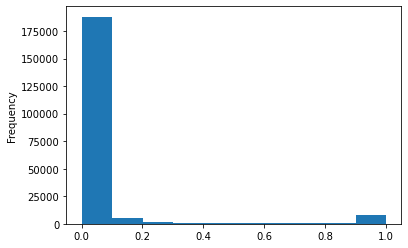

In [25]:
X_test['spliceai'].plot.hist()


In [23]:
X_test.tail()


,aloft.tolerant,aloft.recessive,aloft.dominant,cadd.phred,chasmplus.score,chasmplus.pval,civic.molecular_profile_score,cosmic.variant_count,cosmic_gene.occurrences,cscape.score,...,mutationtaster.prediction_Polymorphism,mutationtaster.model_complex_aae,mutationtaster.model_simple_aae,mutationtaster.model_without_aae,prec.stat_lof-tolerant,prec.stat_recessive,sift.confidence_High,sift.confidence_Low,class,spliceai
208162,0.03175,0.5456,0.38385,8.510,0.073,0.277,7.5,1.0,3655.0,0.121814,...,0,0,0,0,0,1,0,0,1,0.0004
208163,0.03175,0.5456,0.38385,8.510,0.073,0.277,7.5,1.0,3655.0,0.121814,...,0,0,0,0,0,1,0,0,1,0.0004
208164,0.03175,0.5456,0.38385,8.393,0.073,0.277,7.5,1.0,5495.0,0.204376,...,0,0,0,0,0,0,1,0,1,0.0004
208165,0.03175,0.5456,0.38385,8.393,0.073,0.277,7.5,1.0,5495.0,0.204376,...,0,0,0,0,0,0,1,0,1,0.0004
208166,0.03175,0.5456,0.38385,26.400,0.073,0.277,7.5,1.0,2177.0,0.899148,...,0,0,1,0,0,0,1,0,0,0.0004


In [18]:
var.shape


(208167, 15)

In [11]:
var["DITTO"] = y_score
var.head()


,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,clingen.classification,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid,DITTO
0,ENST00000293748,SYNGAP1,"NMD_transcript_variant,synonymous_variant",p.Pro1051=,c.3153T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249,0.0
1,ENST00000418600,SYNGAP1,synonymous_variant,p.Pro1066=,c.3198T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249,0.0
2,ENST00000428982,SYNGAP1,synonymous_variant,p.Pro1007=,c.3021T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249,0.0
3,ENST00000449372,SYNGAP1,synonymous_variant,p.Pro1052=,c.3156T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249,0.0
4,ENST00000628646,SYNGAP1,synonymous_variant,p.Pro1066=,c.3198T>G,chr6,33443750,T,G,complex neurodevelopmental disorder,Definitive,8831.0,NaN,Q96PV0,rs781201249,0.0


In [12]:
var = pd.concat([var.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
var.shape


(208167, 257)

<AxesSubplot:ylabel='Frequency'>

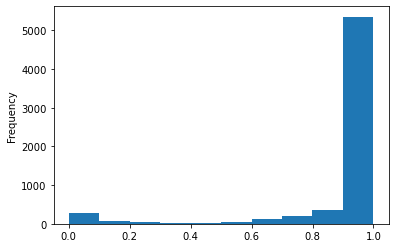

In [16]:
var[var['consequence'].str.contains('splice')]['spliceai'].plot.hist()


In [13]:
bench = var[['DITTO','cadd.phred','clinpred.score','metasvm.score', 'gerp.gerp_rs','spliceai','revel.score','sift.score','dann.score']]
bench.columns = ['DITTO','CADD','ClinPred','MetaSVM','GERP','spliceai','Revel','SIFT','DANN']


In [14]:
default_colors = {
        "DANN": "#de77ae",
        "SIFT": "#fee090",
        "Revel": "#542788",
        "VEST": "#5ab4ac",
        "GERP": "#d8b365",
        "MetaSVM": "#3182bd",
        "ClinPred": "#969696",
        "CADD": "#D55E00",
        "DITTO": "#b2182b",
        "spliceai": "#5ab4ac",
    }


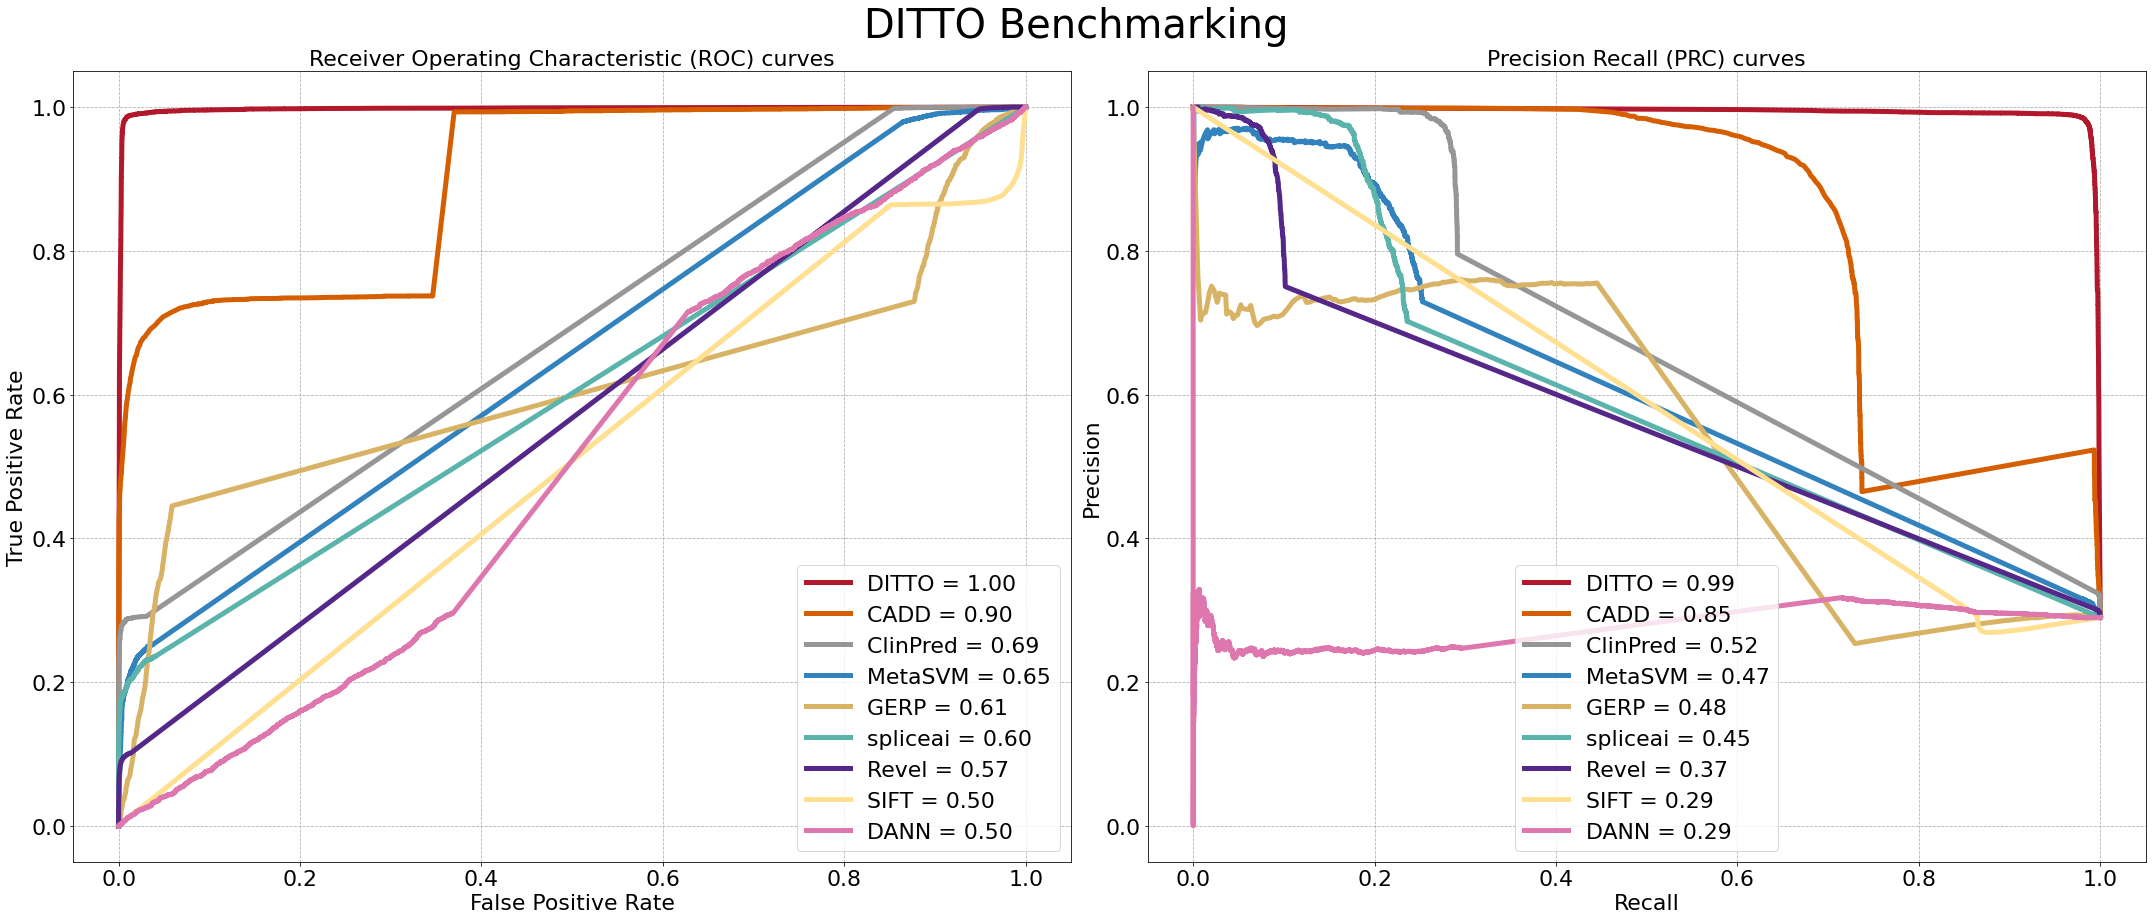

In [26]:
#bench = var[['cadd.phred','clinpred.score', 'chasmplus.score','dann.score','revel.score','metalr.score','metasvm.score','mutation_assessor.score','mutationtaster.score','sift.score','provean.score','vest.score','gerp.gerp_rs','DITTO']]
#bench.columns = ['CADD','ClinPred','chasmplus','DANN','Revel','MetaLR','MetaSVM','mutation_assessor','mutationtaster','SIFT','provean','VEST','GERP','DITTO']
Y_test = 1-var['class']

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(30, 13))

fig.suptitle(f"DITTO Benchmarking", fontsize=40)
fsize = 22
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        x = bench[name].values
        if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=5, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))
        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=5, c= default_colors[name])

# ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
# ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_prc.legend(fontsize=fsize)
ax_roc.legend(fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )




In [21]:
var.tail()


,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,mutationtaster.prediction_Damaging,mutationtaster.prediction_Polymorphism,mutationtaster.model_complex_aae,mutationtaster.model_simple_aae,mutationtaster.model_without_aae,prec.stat_lof-tolerant,prec.stat_recessive,sift.confidence_High,sift.confidence_Low,class
208162,ENST00000413539,DYSF,intron_variant,NaN,c.457+150A>G,chr2,71512071,A,G,NaN,...,0,0,0,0,0,0,1,0,0,1
208163,ENST00000429174,DYSF,intron_variant,NaN,c.457+150A>G,chr2,71512071,A,G,NaN,...,0,0,0,0,0,0,1,0,0,1
208164,ENST00000288135,KIT,synonymous_variant,p.Thr666=,c.1998C>T,chr4,54729342,C,T,NaN,...,0,0,0,0,0,0,0,1,0,1
208165,ENST00000412167,KIT,synonymous_variant,p.Thr662=,c.1986C>T,chr4,54729342,C,T,NaN,...,0,0,0,0,0,0,0,1,0,1
208166,ENST00000328333,COL7A1,missense_variant,p.Gly2037Glu,c.6110G>A,chr3,48575409,C,T,NaN,...,0,0,0,1,0,0,0,1,0,0


In [15]:
var1 = var.sort_values(by="DITTO", ascending=False).drop_duplicates(subset=['chrom', 'pos', 'ref_base', 'alt_base'], keep='first').reset_index(drop=True)
var1.tail()


,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,mutationtaster.prediction_Polymorphism,mutationtaster.model_complex_aae,mutationtaster.model_simple_aae,mutationtaster.model_without_aae,prec.stat_lof-tolerant,prec.stat_recessive,sift.confidence_High,sift.confidence_Low,class,spliceai
37022,ENST00000591909,TUBB6,3_prime_UTR_variant,NaN,c.*354C>G,chr18,12329537,C,G,NaN,...,0,0,0,0,0,0,0,0,1,0.0004
37023,ENST00000289672,PKD1L1,intron_variant,NaN,c.4961-38C>T,chr7,47847109,G,A,NaN,...,0,0,0,0,0,0,0,0,1,0.0004
37024,ENST00000437951,PTCH1,synonymous_variant,p.Ser1169=,c.3507C>T,chr9,95449168,G,A,nevoid basal cell carcinoma syndrome,...,0,0,0,0,0,0,1,0,1,0.0004
37025,ENST00000644285,ANKRD11,intron_variant,NaN,c.745-6013G>A,chr16,89281204,C,T,NaN,...,0,0,0,0,0,0,0,0,1,0.0004
37026,ENST00000436005,PNKD,intron_variant,NaN,c.173-24C>T,chr2,218340005,C,T,NaN,...,0,0,0,0,0,0,0,0,1,0.0004


In [28]:
var1.chrom.value_counts()


chr2     3648
chr17    3168
chr1     2792
chr11    2221
chr16    2155
chr5     1953
chr3     1857
chr19    1839
chr12    1777
chr9     1730
chr7     1677
chr13    1611
chrX     1546
chr6     1244
chr10    1227
chr15    1198
chr14    1088
chr4     1027
chr8     1007
chr22     706
chr20     616
chr18     555
chr21     385
Name: chrom, dtype: int64

In [29]:
var1['consequence'].value_counts()


synonymous_variant                                                                  8683
intron_variant                                                                      6928
missense_variant                                                                    4066
processed_transcript                                                                2703
stop_gained                                                                         1944
frameshift_truncation                                                               1907
NMD_transcript_variant,3_prime_UTR_variant                                          1405
intron_variant,splice_site_variant                                                   919
frameshift_elongation                                                                900
intron_variant,NMD_transcript_variant                                                647
2kb_downstream_variant                                                               624
2kb_upstream_variant 

In [27]:
#var1 = var1.merge(amis, left_on=['chrom','pos','ref_base','alt_base'], right_on=['#CHROM','POS','REF','ALT'], how='left')
#var1.shape


In [16]:
Y_test = 1-var1['class']
Y_test.head()


0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [17]:
y_score = var1['DITTO']
y_score.head()


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: DITTO, dtype: float32

Precision: 0.9897399187091046
Recall: 0.9896561968293408
ROC_AUC: 0.9971389293121536
PRC_AUC: 0.9917333144301461
Accuracy: 0.9896561968293408
Confusion matrix:
[[26683   264]
 [  119  9961]]


Text(0.5, 1.0, 'Confusion matrix for test variants')

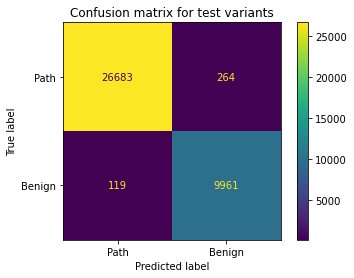

In [20]:
prc = precision_score(Y_test, y_score.round(), average="weighted")
recall = recall_score(Y_test, y_score.round(), average="weighted")
roc_auc = roc_auc_score(Y_test, y_score)
prc_auc = average_precision_score(Y_test, y_score, average="weighted")
# roc_auc = roc_auc_score(Y_test, np.argmax(y_score, axis=1))
accuracy = accuracy_score(Y_test, y_score.round())
# score = clf.score(X_train, Y_train)
matrix = confusion_matrix(Y_test, y_score.round())
cm = confusion_matrix(Y_test, y_score.round())
print(f"Precision: {prc}\nRecall: {recall}\nROC_AUC: {roc_auc}\nPRC_AUC: {prc_auc}\nAccuracy: {accuracy}\nConfusion matrix:\n{matrix}")
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Path', 'Benign'])
cm.plot()
plt.title(f"Confusion matrix for test variants", fontsize=12)


In [18]:
bench = var1[['DITTO','cadd.phred','clinpred.score','metasvm.score', 'gerp.gerp_rs','spliceai','revel.score','dann.score','sift.score']]
bench.columns = ['DITTO','CADD','ClinPred','MetaSVM','GERP','spliceai','Revel','DANN','SIFT']



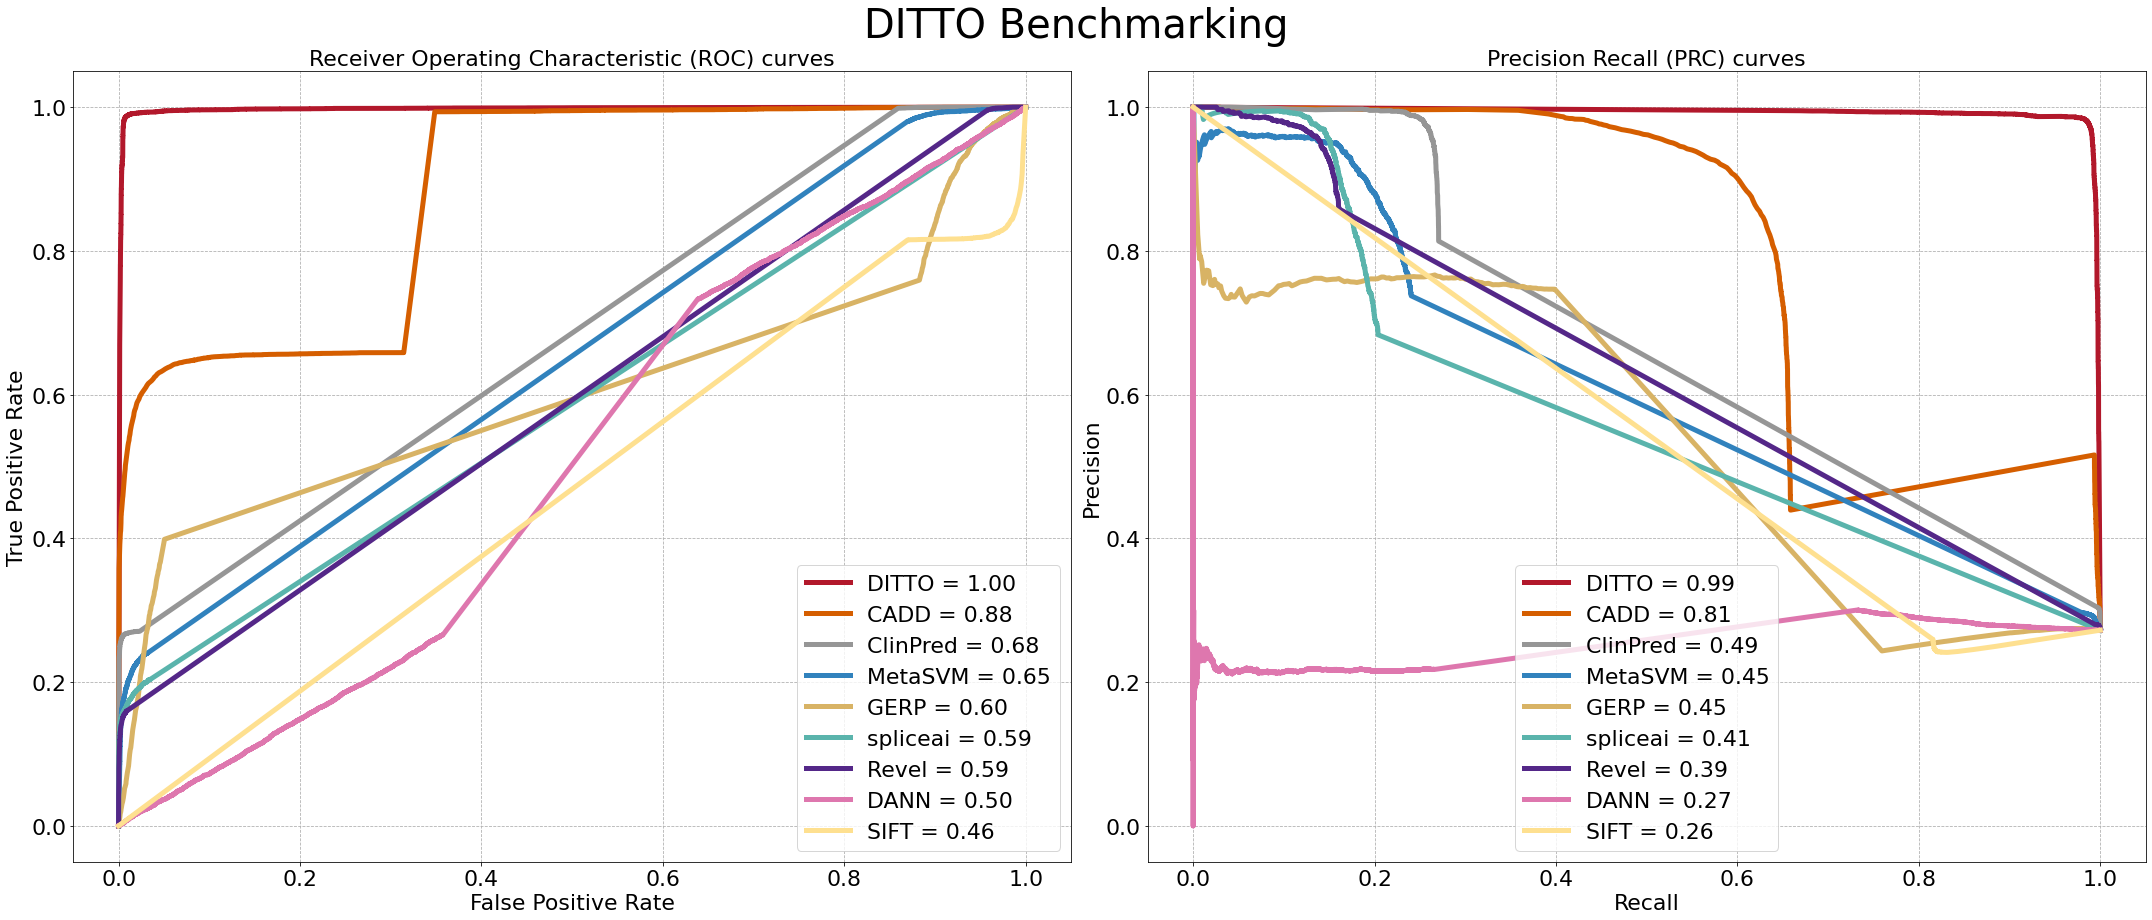

In [33]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(30, 13))

fig.suptitle(f"DITTO Benchmarking", fontsize=40)
fsize = 22
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        x = bench[name].values
        if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=5, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))
        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=5, c= default_colors[name])

ax_prc.legend(fontsize=fsize)# bbox_to_anchor=(1,0.5), loc="center left",
ax_roc.legend(fontsize=fsize)# bbox_to_anchor=(1,0.5), loc="center left",
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


In [29]:
var.chrom.unique()


array(['chr6', 'chr13', 'chrX', 'chr14', 'chr11', 'chr18', 'chr12',
       'chr17', 'chr2', 'chr15', 'chr9', 'chr1', 'chr8', 'chr4', 'chr16',
       'chr21', 'chr5', 'chr19', 'chr3', 'chr10', 'chr7', 'chr20',
       'chr22'], dtype=object)

In [21]:
acc_scores_chr = {}
prc_scores_chr = {}
f1_scores_chr = {}
for name in var1.chrom.unique():
    acc_scores_chr[name] = {}
    prc_scores_chr[name] = {}
    f1_scores_chr[name] = {}
    for clf in bench.columns:
        index_list = var1[var1.chrom == name].index
        x = bench[bench.index.isin(index_list)][clf].values
        if clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            x_norm = x

        acc = accuracy_score(Y_test[index_list],  x_norm.round())
        acc = "{:.2f}".format(acc)
        acc_scores_chr[name][clf] = acc

        prc = precision_score(Y_test[index_list],  x_norm.round())
        prc = "{:.2f}".format(prc)
        prc_scores_chr[name][clf] = prc

        f1 = f1_score(Y_test[index_list],  x_norm.round())
        f1_scores_chr[name][clf] = "{:.2f}".format(f1)

pd.DataFrame(f1_scores_chr).to_csv("/Users/tarunmamidi/Documents/Development/DITTO/data/processed/f1_scores_chr_overall_1_transcript.csv")


In [20]:
f1_scores_chr


{'chr3': {'DITTO': '0.99',
  'CADD': '0.71',
  'ClinPred': '0.51',
  'MetaSVM': '0.40',
  'GERP': '0.45',
  'spliceai': '0.29',
  'Revel': '0.32',
  'DANN': '0.43',
  'SIFT': '0.39'},
 'chr19': {'DITTO': '0.98',
  'CADD': '0.51',
  'ClinPred': '0.59',
  'MetaSVM': '0.54',
  'GERP': '0.34',
  'spliceai': '0.22',
  'Revel': '0.35',
  'DANN': '0.35',
  'SIFT': '0.27'},
 'chr11': {'DITTO': '0.98',
  'CADD': '0.63',
  'ClinPred': '0.41',
  'MetaSVM': '0.37',
  'GERP': '0.49',
  'spliceai': '0.30',
  'Revel': '0.28',
  'DANN': '0.46',
  'SIFT': '0.43'},
 'chr1': {'DITTO': '0.98',
  'CADD': '0.71',
  'ClinPred': '0.50',
  'MetaSVM': '0.42',
  'GERP': '0.40',
  'spliceai': '0.23',
  'Revel': '0.36',
  'DANN': '0.40',
  'SIFT': '0.33'},
 'chr17': {'DITTO': '0.98',
  'CADD': '0.52',
  'ClinPred': '0.33',
  'MetaSVM': '0.27',
  'GERP': '0.59',
  'spliceai': '0.28',
  'Revel': '0.19',
  'DANN': '0.58',
  'SIFT': '0.53'},
 'chr8': {'DITTO': '0.98',
  'CADD': '0.74',
  'ClinPred': '0.28',
  'MetaSVM

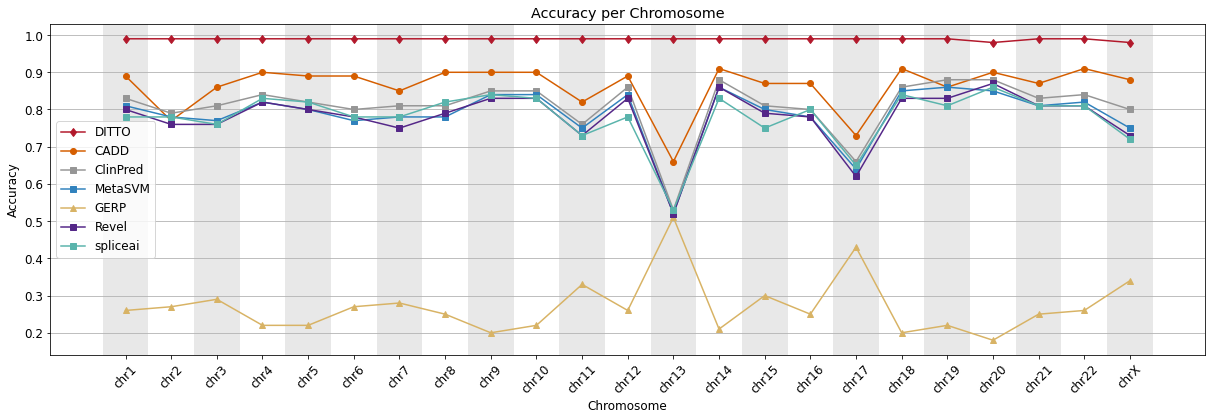

In [34]:
# Extract the chromosome names and values in the specified order
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
 'chr20', 'chr21', 'chr22', 'chrX']
CADD_values = [float(acc_scores_chr[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(acc_scores_chr[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(acc_scores_chr[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(acc_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(acc_scores_chr[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(acc_scores_chr[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(acc_scores_chr[chr]['spliceai']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceai', linestyle='-', c= default_colors['spliceai'])

plt.xlabel('Chromosome')
plt.ylabel('Accuracy')
plt.title('Accuracy per Chromosome')
plt.legend()
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels

plt.tight_layout()
plt.show()


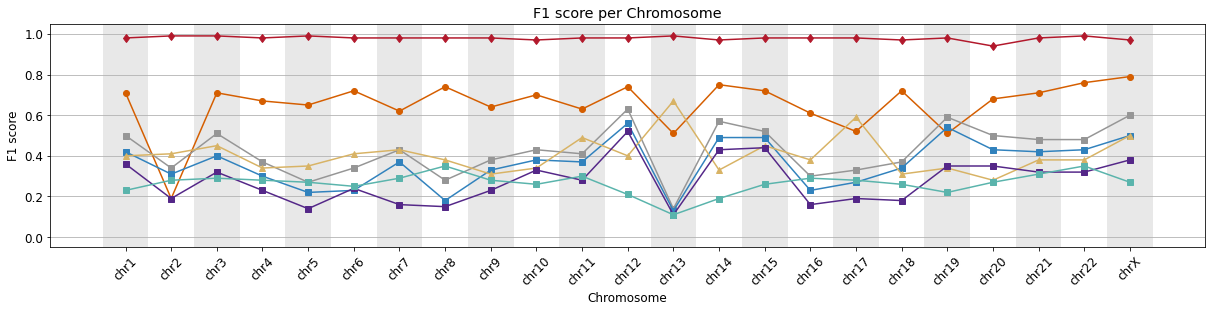

In [41]:
# Extract the chromosome names and values in the specified order
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
 'chr20', 'chr21', 'chr22', 'chrX']
CADD_values = [float(f1_scores_chr[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(f1_scores_chr[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(f1_scores_chr[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(f1_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(f1_scores_chr[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(f1_scores_chr[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(f1_scores_chr[chr]['spliceai']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 4.5))
plt.rcParams.update({'font.size': 12})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceai', linestyle='-', c= default_colors['spliceai'])

plt.xlabel('Chromosome')
plt.ylabel('F1 score')
plt.title('F1 score per Chromosome')
# plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()


In [22]:
# Assuming you have a DataFrame called df with a column called 'column1'
# and a dictionary called my_dict

var1['so'] = var1['consequence'].map(var_dict)
var1['so1'] = var1['so']


In [23]:
pd.pivot_table(var1,  index='so', columns='chrom', values='so1',
                          aggfunc='count').T.to_csv("/Users/tarunmamidi/Documents/Development/DITTO/data/processed/var_number_type_chr.csv") #.sort_values(by=['low_impact','high_impact'], ascending=False)
#var1['chromo'] = var1['chrom']
#pd.pivot_table(var1,  index='chromo', columns='so', values='chrom',
#                          aggfunc='count')#.sort_values(by=['low_impact','high_impact'], ascending=False)


<AxesSubplot:xlabel='so'>

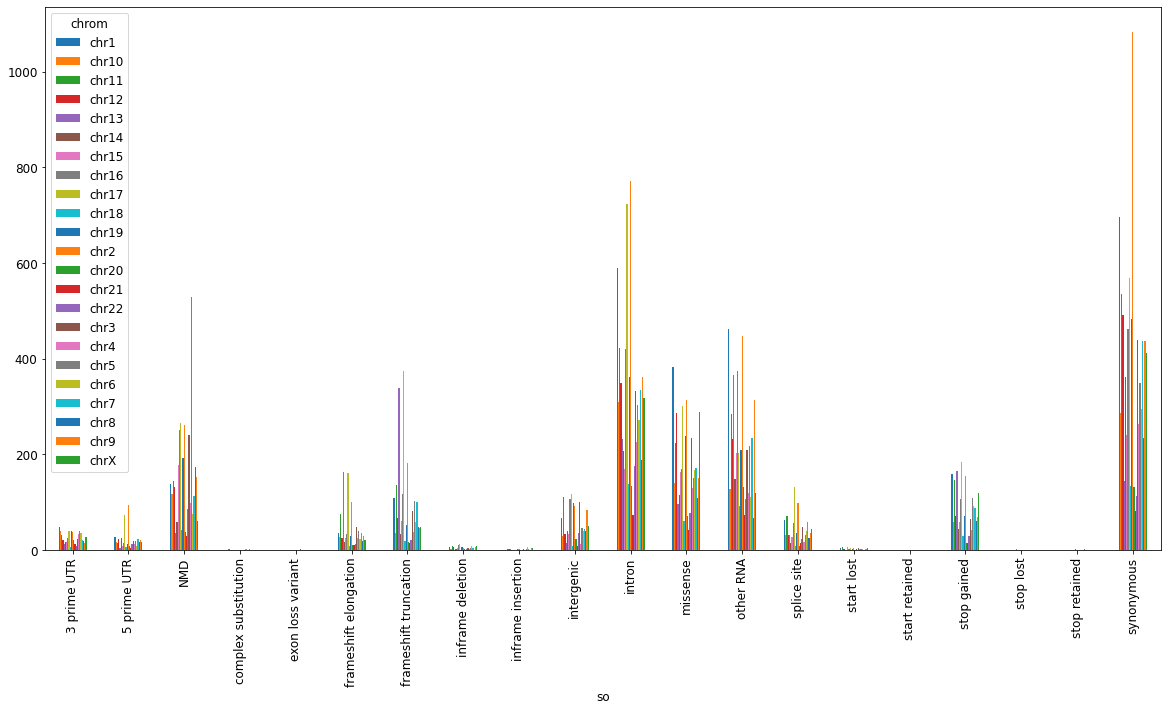

In [44]:
pd.pivot_table(var1,  index='so', columns='chrom', values='so1',
                          aggfunc='count').plot(kind='bar', figsize=(20,10), linewidth=3)


In [36]:
var1[var1['chrom']=='chr13']['clingen.disease'].value_counts()


breast-ovarian cancer, familial, susceptibility to, 2;Fanconi anemia complementation group D1    1137
Wilson disease                                                                                     70
autosomal recessive nonsyndromic deafness;syndromic genetic deafness                               26
xeroderma pigmentosum group G                                                                       9
auditory neuropathy                                                                                 8
Waardenburg syndrome type 4A;Waardenburg syndrome type 4A                                           4
nonsyndromic genetic deafness;Clouston syndrome                                                     4
Leigh syndrome                                                                                      2
factor VII deficiency                                                                               2
high myopia-sensorineural deafness syndrome                                       

Text(0.5, 1.0, 'Confusion matrix of DITTO for chr13 variants')

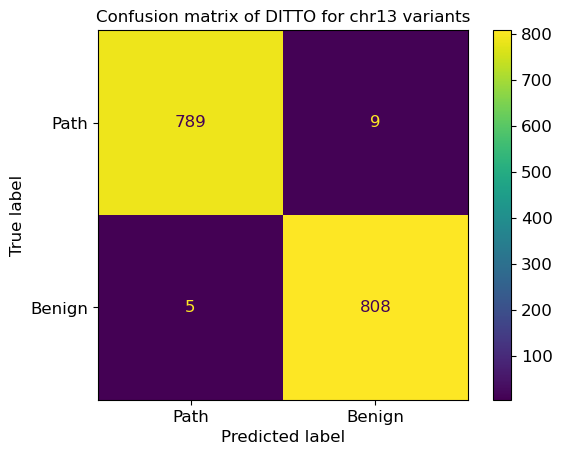

In [66]:
name = 'chr13'
clf = 'DITTO'
index_list = var1[var1.chrom == name].index
x = bench[bench.index.isin(index_list)][clf].values

cm = confusion_matrix(Y_test[index_list],x.round())
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Path', 'Benign'])
cm.plot()
plt.title(f"Confusion matrix of DITTO for chr13 variants", fontsize=12)


In [77]:
var1.consequence.value_counts()


synonymous_variant                                                                  8683
intron_variant                                                                      6928
missense_variant                                                                    4066
processed_transcript                                                                2703
stop_gained                                                                         1944
frameshift_truncation                                                               1907
NMD_transcript_variant,3_prime_UTR_variant                                          1405
intron_variant,splice_site_variant                                                   919
frameshift_elongation                                                                900
intron_variant,NMD_transcript_variant                                                647
2kb_downstream_variant                                                               624
2kb_upstream_variant 

In [24]:
var_type_order = ['NMD', 'missense', 'stop lost','stop gained', 'start lost','synonymous', 'splice site','frameshift truncation','frameshift elongation', 'complex substitution', 'exon loss variant', 'inframe insertion','inframe deletion','intron', '3 prime UTR',  '5 prime UTR', 'other RNA','intergenic']


In [25]:

roc_scores = {}
prc_scores = {}
f1_scores = {}

for consq in var_type_order:
        roc_scores[consq] = {}
        prc_scores[consq] = {}
        f1_scores[consq] = {}

        index_list = var1[var1.so == consq].index
        missense = bench[bench.index.isin(index_list)]

        missense_y = Y_test[Y_test.index.isin(index_list)].values

        for name in list(missense.columns):
                if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
                    x_norm = (missense-np.min(missense))/(np.max(missense)-np.min(missense))
                else:
                    x_norm = missense
                try:
                        auc = accuracy_score(missense_y, x_norm[name].fillna(0).values)
                except:
                        auc=0
                roc_scores[consq][name] = round(auc,2)
                try:
                        prc = precision_score(missense_y, x_norm[name].fillna(0).values)
                except:
                        prc=0
                prc_scores[consq][name] = round(prc,2)
                try:
                        f1 = f1_score(missense_y, x_norm[name].fillna(0).values.round())
                except:
                        f1=0
                f1_scores[consq][name] = round(f1,2)

#pd.DataFrame(roc_scores).to_csv("/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO4NF/data/processed/tuning/NN_roc_scores.csv")
#pd.DataFrame(prc_scores).to_csv("/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO4NF/data/processed/tuning/NN_prc_scores.csv")
pd.DataFrame(f1_scores).to_csv("/Users/tarunmamidi/Documents/Development/DITTO/data/processed/f1_scores_type_overall_1_transcript.csv")


In [26]:
f1_scores


{'NMD': {'DITTO': 0.98,
  'CADD': 0.72,
  'ClinPred': 0.42,
  'MetaSVM': 0.33,
  'GERP': 0.34,
  'spliceai': 0.38,
  'Revel': 0.01,
  'DANN': 0.33,
  'SIFT': 0.33},
 'missense': {'DITTO': 0.98,
  'CADD': 0.79,
  'ClinPred': 0.97,
  'MetaSVM': 0.88,
  'GERP': 0.68,
  'spliceai': 0.07,
  'Revel': 0.83,
  'DANN': 0.61,
  'SIFT': 0.15},
 'stop lost': {'DITTO': 0.86,
  'CADD': 0.86,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.86,
  'spliceai': 0.0,
  'Revel': 0.0,
  'DANN': 1.0,
  'SIFT': 1.0},
 'stop gained': {'DITTO': 1.0,
  'CADD': 0.93,
  'ClinPred': 0.08,
  'MetaSVM': 0.99,
  'GERP': 0.98,
  'spliceai': 0.04,
  'Revel': 0.0,
  'DANN': 0.89,
  'SIFT': 1.0},
 'start lost': {'DITTO': 0.98,
  'CADD': 0.96,
  'ClinPred': 0.97,
  'MetaSVM': 0.7,
  'GERP': 0.96,
  'spliceai': 0.03,
  'Revel': 0.67,
  'DANN': 0.9,
  'SIFT': 0.24},
 'synonymous': {'DITTO': 0.83,
  'CADD': 0.11,
  'ClinPred': 0.17,
  'MetaSVM': 0.15,
  'GERP': 0.0,
  'spliceai': 0.56,
  'Revel': 0.0,
  'DANN': 0.0,
  'SIFT'

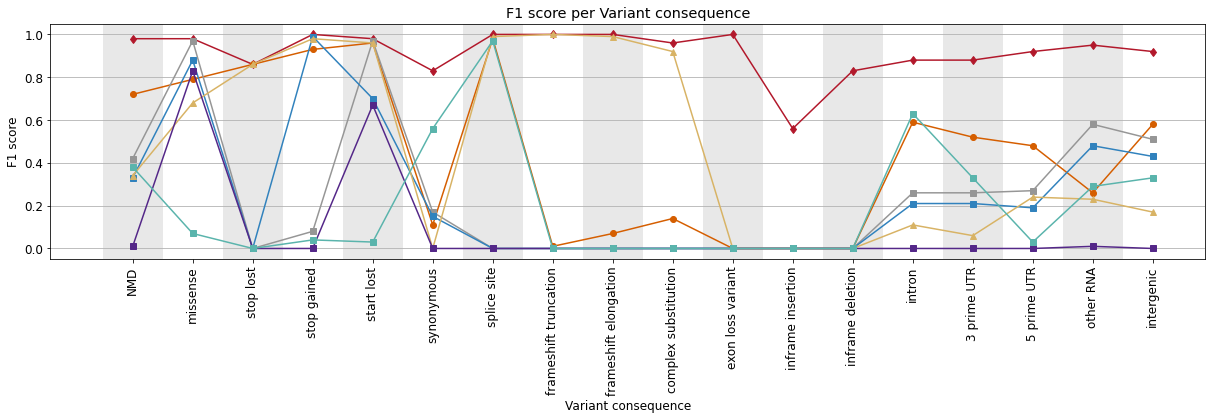

In [49]:
# Extract the chromosome names and values in the specified order
chromosomes = f1_scores.keys()
CADD_values = [float(f1_scores[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(f1_scores[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(f1_scores[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(f1_scores[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(f1_scores[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(f1_scores[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(f1_scores[chr]['spliceai']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceAi', linestyle='-', c= default_colors['spliceai'])

plt.xlabel('Variant consequence')
plt.ylabel('F1 score')
plt.title('F1 score per Variant consequence')
#plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=90)  # Set x-axis labels
#plt.gca().set_xticklabels(var_type_order)
plt.tight_layout()
plt.show()


In [71]:
var1[var1['so'].isin(['start retained', 'stop retained'])][['consequence','so','DITTO','cadd.phred','spliceai','gene','protein_hgvs','cdna_hgvs','chrom','pos','ref_base','alt_base','transcript','clingen.classification','class']]


,consequence,so,DITTO,cadd.phred,spliceai,gene,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,transcript,clingen.classification,class
11729,start_retained_variant,start retained,2.516013e-02,9.129,0.0004,DOLK,p.Met1=,c.1dup,chr9,128947303,-,T,ENST00000372586,NaN,1
25154,stop_retained_variant,stop retained,5.960464e-08,6.865,0.0004,REST,p.Ter315=,c.944A>G,chr4,56932151,A,G,ENST00000622863,NaN,1
30215,stop_retained_variant,stop retained,0.000000e+00,4.401,0.0004,SLC26A2,p.Ter740=,c.2220A>G,chr5,149981813,A,G,ENST00000286298,NaN,1
31259,stop_retained_variant,stop retained,0.000000e+00,6.762,0.0004,GM2A,p.Ter194=,c.582A>G,chr5,151267451,A,G,ENST00000357164,NaN,1
35592,stop_retained_variant,stop retained,0.000000e+00,7.377,0.0004,CEACAM16,p.Ter426=,c.1278A>G,chr19,44710506,A,G,ENST00000587331,Moderate,1
35803,stop_retained_variant,stop retained,0.000000e+00,8.260,0.0004,BLOC1S3,p.Ter203=,c.609G>A,chr19,45179905,G,A,ENST00000587722,NaN,1


In [42]:
print(var1[var1['consequence'].str.contains("missense_variant")].shape)
var1[var1['consequence'].str.contains("missense_variant")].chrom.value_counts()


(4376, 256)


chr1     405
chr2     329
chr17    320
chrX     298
chr12    296
chr3     252
chr19    249
chr11    249
chr16    188
chr15    186
chr7     185
chr6     176
chr5     173
chr9     169
chr10    144
chr4     143
chr14    123
chr8     119
chr13     99
chr22     85
chr20     75
chr18     64
chr21     49
Name: chrom, dtype: int64

In [28]:
bench = var1[['DITTO','clinpred.score','metasvm.score','vest.score','revel.score','cadd.phred','gerp.gerp_rs','dann.score','sift.score','spliceai']]
bench.columns = ['DITTO','ClinPred','MetaSVM','VEST','Revel','CADD','GERP','DANN','SIFT','spliceai']


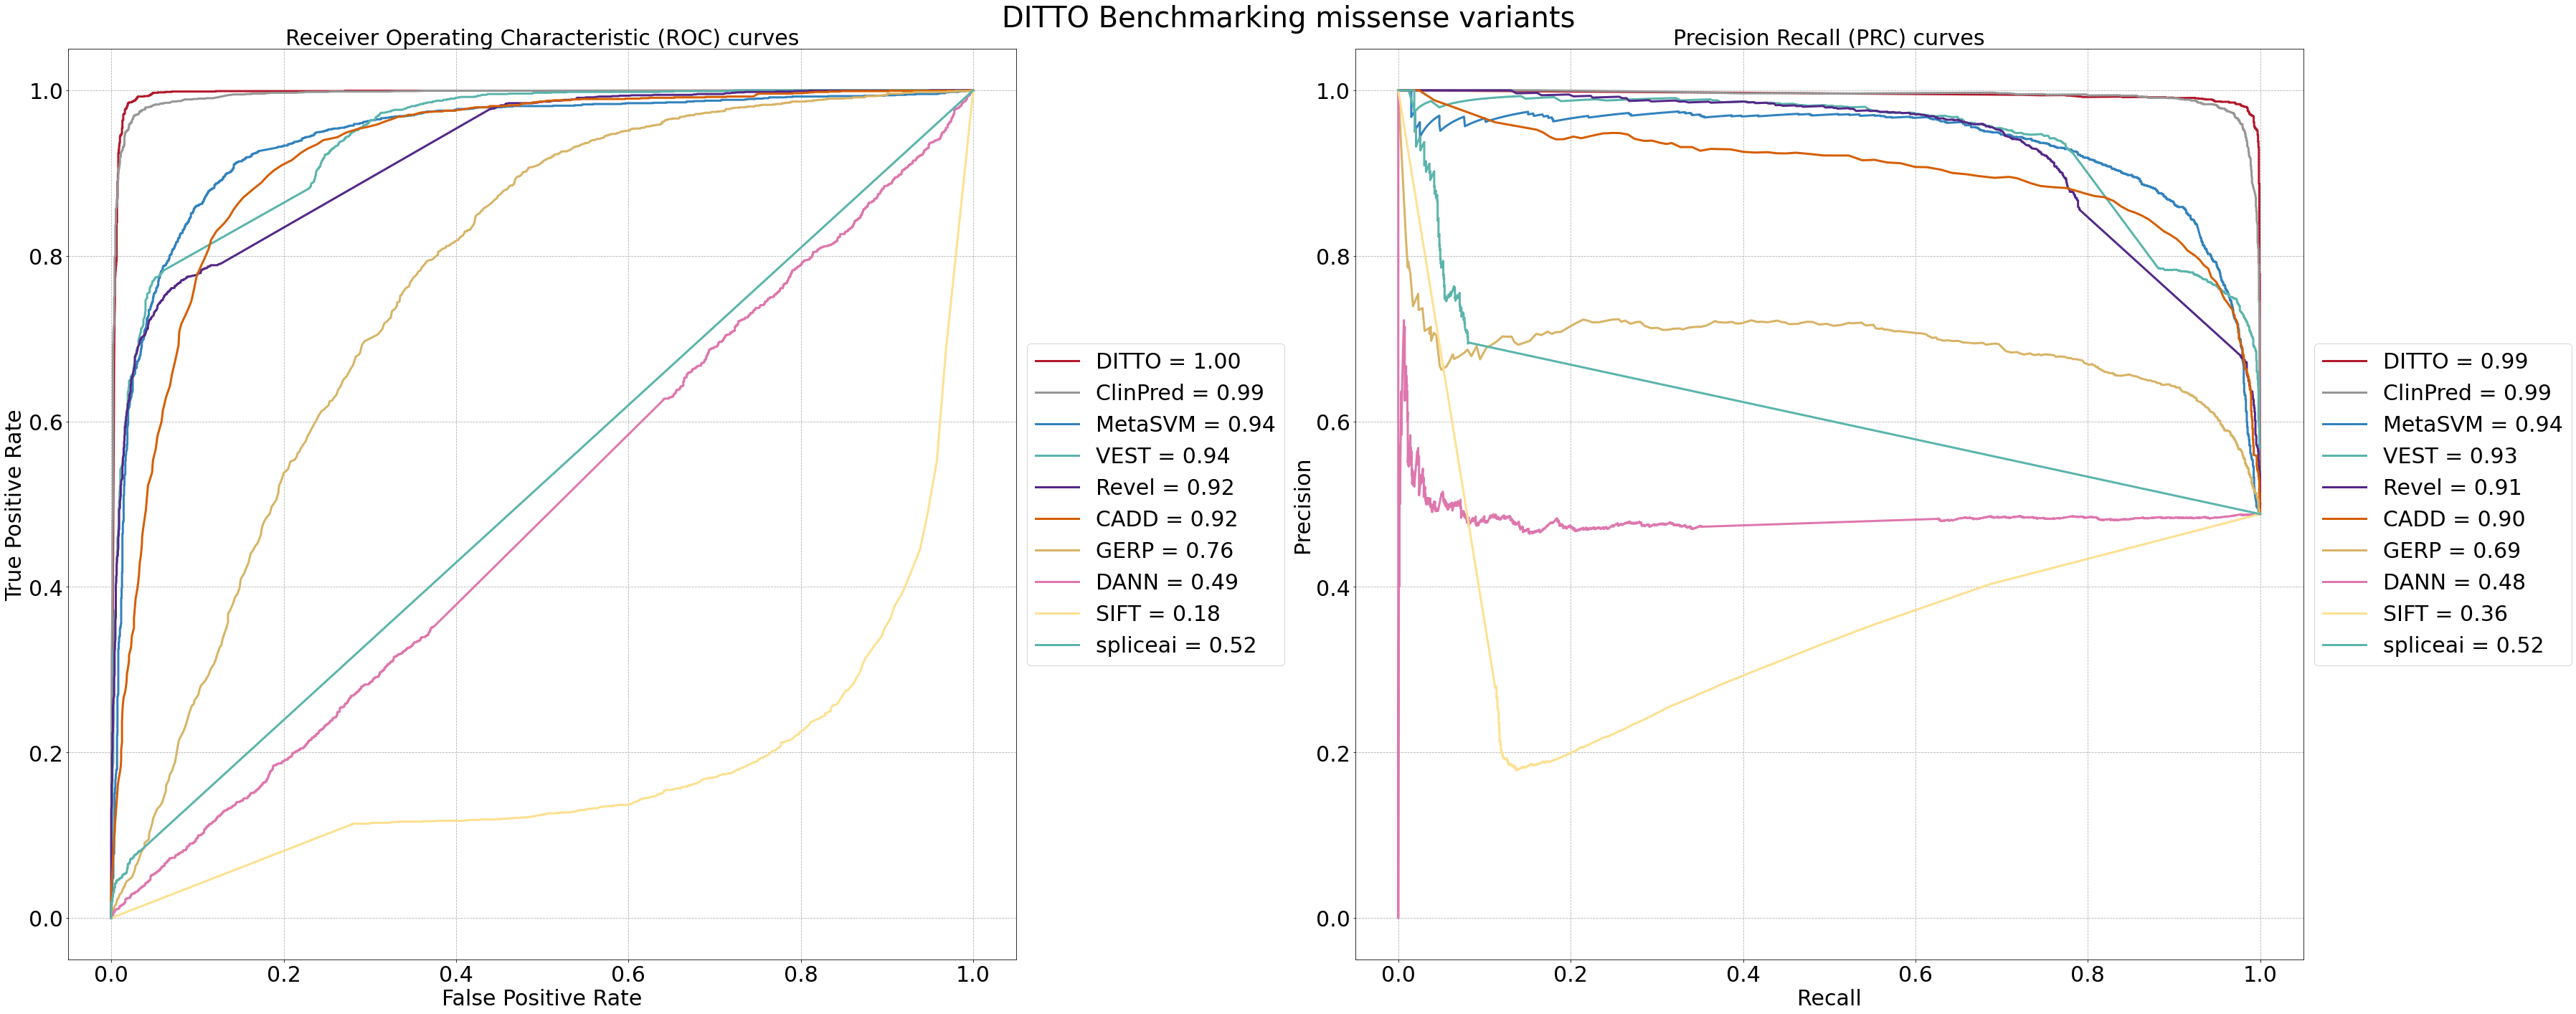

In [29]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking missense variants", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        index_list = var1[var1.so == 'missense'].index
        x = bench[bench.index.isin(index_list)][name].values
        Y_test1 = Y_test[Y_test.index.isin(index_list)].values
        if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test1, y_true)
        auc = roc_auc_score(Y_test1, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=3, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test1, y_true)
        prc = average_precision_score(Y_test1, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=3, c= default_colors[name])
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


In [76]:
var1['class1'] = var1['class']


In [30]:
def f1plot(var_type):
    acc_scores_chr = {}
    prc_scores_chr = {}
    f1_scores_chr = {}
    for name in var1.chrom.unique():
        acc_scores_chr[name] = {}
        prc_scores_chr[name] = {}
        f1_scores_chr[name] = {}
        for clf in bench.columns:
            index_list = var1[(var1.chrom == name) & (var1['so'] == var_type)].index
            x = bench[bench.index.isin(index_list)][clf].values
            if np.unique(x).size == 1:
                x_norm = np.zeros_like(x)
            elif clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
                x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
            else:
                x_norm = x

            acc = accuracy_score(Y_test[index_list],  x_norm.round())
            acc = "{:.2f}".format(acc)
            acc_scores_chr[name][clf] = acc

            prc = precision_score(Y_test[index_list],  x_norm.round())
            prc = "{:.2f}".format(prc)
            prc_scores_chr[name][clf] = prc

            f1 = f1_score(Y_test[index_list],  x_norm.round())
            f1_scores_chr[name][clf] = "{:.2f}".format(f1)
            pd.DataFrame(f1_scores_chr).to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO/data/processed/f1_scores_{var_type}_chr_1_transcript.csv")



    # Extract the chromosome names and values in the specified order
    chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
     'chr20', 'chr21', 'chr22', 'chrX']
    CADD_values = [float(f1_scores_chr[chr]['CADD']) for chr in chromosomes]
    ClinPred_values = [float(f1_scores_chr[chr]['ClinPred']) for chr in chromosomes]
    Revel_values = [float(f1_scores_chr[chr]['Revel']) for chr in chromosomes]
    MetaSVM_values = [float(f1_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
    GERP_values = [float(f1_scores_chr[chr]['GERP']) for chr in chromosomes]
    DITTO_values = [float(f1_scores_chr[chr]['DITTO']) for chr in chromosomes]
    spliceai_values = [float(f1_scores_chr[chr]['spliceai']) for chr in chromosomes]

    # Create a Manhattan-style bar plot
    plt.figure(figsize=(17, 4.5))
    plt.rcParams.update({'font.size': 12})
    plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
    plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
    plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
    plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
    plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
    plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
    plt.plot(chromosomes, spliceai_values, marker='s', label='spliceAI', linestyle='-', c= default_colors['spliceai'])

    plt.xlabel('Chromosome')
    plt.ylabel('F1 score')
    plt.title(f'F1 score per Chromosome for {var_type} variants')
    plt.legend()
    plt.grid(axis='y')

    # Add shaded rectangles instead of grid lines
    ax = plt.gca()
    for i in range(len(chromosomes)):
        if i % 2 == 0:  # Shade every other chromosome
            ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

    plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()


In [118]:
pd.pivot_table(var1[var1['so'] == "intergenic"],  index='class', columns='chrom', values='class1',
                          aggfunc='count').T


class,0,1
chrom,,
chr1,4.0,64.0
chr10,NaN,30.0
chr11,14.0,97.0
chr12,1.0,32.0
chr13,2.0,13.0
chr14,2.0,38.0
chr15,2.0,31.0
chr16,8.0,98.0
chr17,14.0,104.0


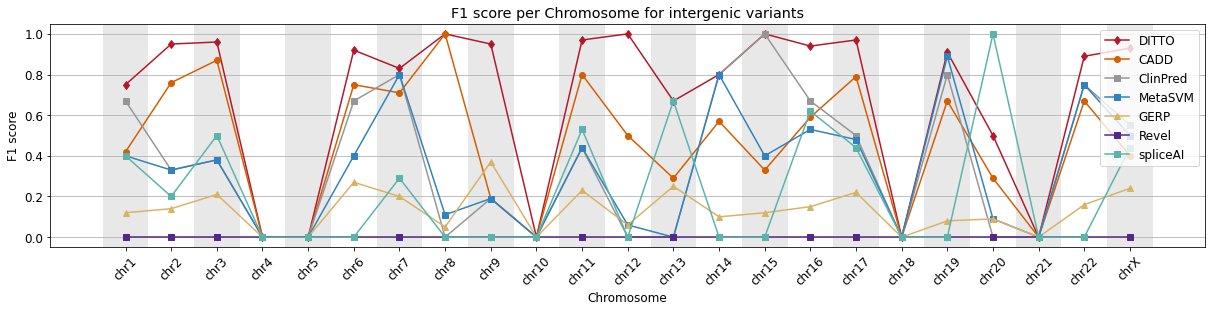

In [31]:
f1plot('intergenic')


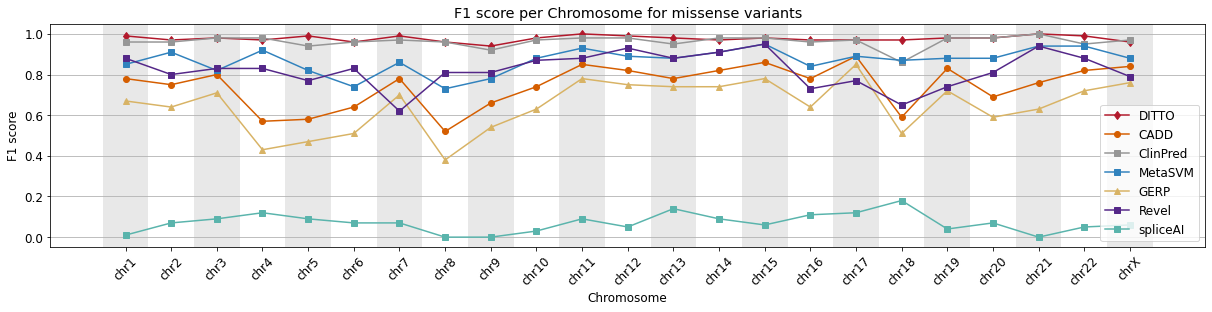

In [32]:
f1plot('missense')


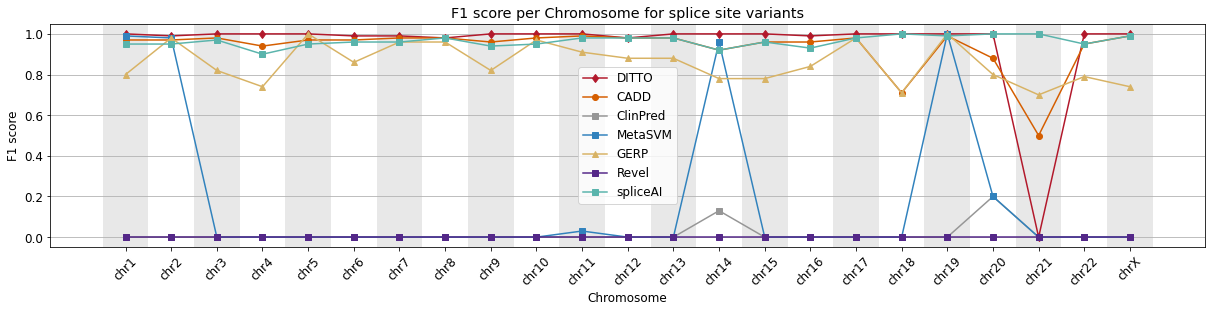

In [33]:
f1plot('splice site')


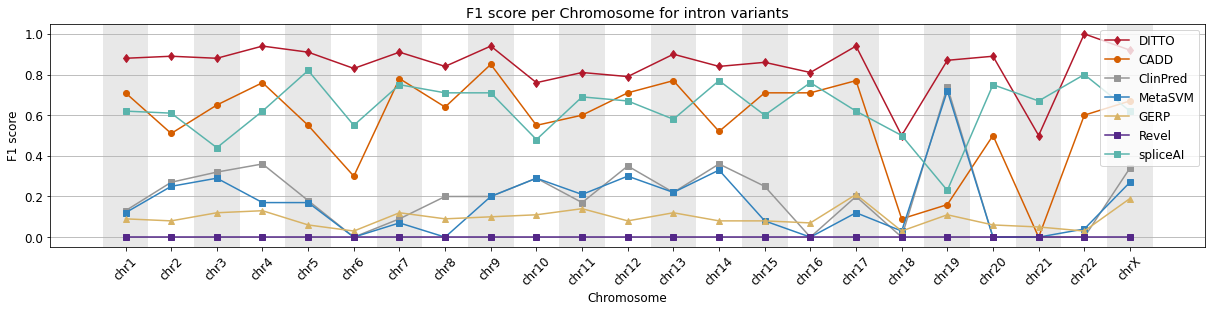

In [34]:
f1plot('intron')


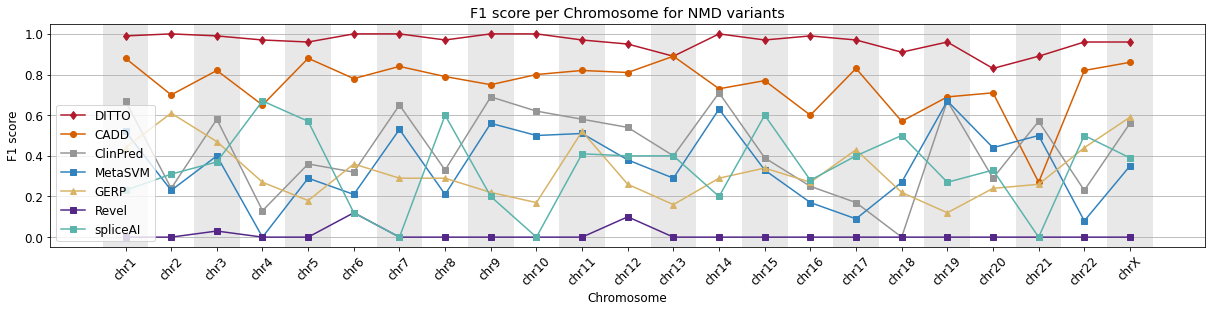

In [35]:
f1plot('NMD')


In [97]:
var1[var1['so'] == "NMD"].consequence.unique()


array(['NMD_transcript_variant,3_prime_UTR_variant',
       'NMD_transcript_variant,stop_gained', 'NSD_transcript',
       'NMD_transcript_variant', 'intron_variant,NMD_transcript_variant',
       'intron_variant,NMD_transcript_variant,splice_site_variant',
       'frameshift_truncation,NMD_transcript_variant',
       '2kb_downstream_variant,NMD_transcript_variant',
       'frameshift_truncation,NMD_transcript_variant,stop_gained',
       'missense_variant,NMD_transcript_variant',
       '2kb_upstream_variant,NSD_transcript',
       '2kb_upstream_variant,NMD_transcript_variant',
       'frameshift_elongation,NMD_transcript_variant',
       'complex_substitution,frameshift_truncation,NMD_transcript_variant',
       'NMD_transcript_variant,synonymous_variant',
       'inframe_deletion,NMD_transcript_variant',
       'complex_substitution,frameshift_elongation,intron_variant,NMD_transcript_variant',
       '2kb_downstream_variant,NSD_transcript',
       'missense_variant,start_lost,NMD_tr

In [100]:
var1['consequence1'] = var1['consequence']
pd.pivot_table(var1[var1['so'] == "NMD"],  index='class', columns='consequence', values='class1',
                          aggfunc='count').T


class,0,1
consequence,,
"2kb_downstream_variant,NMD_transcript_variant",38.0,305.0
"2kb_downstream_variant,NSD_transcript",3.0,1.0
"2kb_upstream_variant,NMD_transcript_variant",4.0,45.0
"2kb_upstream_variant,NSD_transcript",1.0,6.0
NMD_transcript_variant,4.0,1.0
"NMD_transcript_variant,3_prime_UTR_variant",220.0,1185.0
"NMD_transcript_variant,5_prime_UTR_variant",1.0,17.0
"NMD_transcript_variant,splice_site_variant",1.0,NaN
"NMD_transcript_variant,stop_gained",87.0,8.0


In [130]:
extra_cols = ['DITTO','class','spliceai','so','so1','class1','consequence1']


(4082, 239)


  0%|          | 0/50 [00:00<?, ?it/s]

702/702 [==============================] - 1s 1ms/step


  2%|▏         | 1/50 [00:01<01:25,  1.74s/it]

701/701 [==============================] - 1s 1ms/step


  4%|▍         | 2/50 [00:03<01:21,  1.70s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 3/50 [00:05<01:19,  1.70s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 4/50 [00:06<01:15,  1.63s/it]

702/702 [==============================] - 1s 1ms/step


 10%|█         | 5/50 [00:08<01:12,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 6/50 [00:09<01:11,  1.63s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 7/50 [00:11<01:09,  1.61s/it]

701/701 [==============================] - 1s 1ms/step


 16%|█▌        | 8/50 [00:12<01:06,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 9/50 [00:14<01:07,  1.65s/it]

703/703 [==============================] - 1s 1ms/step


 20%|██        | 10/50 [00:16<01:06,  1.65s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 11/50 [00:18<01:04,  1.65s/it]

701/701 [==============================] - 1s 1ms/step


 24%|██▍       | 12/50 [00:19<01:03,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 13/50 [00:21<01:01,  1.65s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 14/50 [00:23<01:00,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 15/50 [00:24<00:59,  1.69s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 16/50 [00:26<00:56,  1.67s/it]

702/702 [==============================] - 1s 1ms/step


 34%|███▍      | 17/50 [00:28<00:54,  1.65s/it]

702/702 [==============================] - 1s 1ms/step


 36%|███▌      | 18/50 [00:29<00:52,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 19/50 [00:31<00:51,  1.66s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 20/50 [00:33<00:49,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 21/50 [00:34<00:47,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 22/50 [00:36<00:45,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 23/50 [00:37<00:43,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 24/50 [00:39<00:42,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 25/50 [00:41<00:40,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 26/50 [00:42<00:38,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 27/50 [00:44<00:37,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 28/50 [00:45<00:35,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 29/50 [00:47<00:33,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 30/50 [00:49<00:31,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 31/50 [00:50<00:30,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 32/50 [00:52<00:28,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 33/50 [00:53<00:27,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 34/50 [00:55<00:25,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 35/50 [00:57<00:24,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 36/50 [00:58<00:22,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 37/50 [01:00<00:20,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 38/50 [01:01<00:19,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 39/50 [01:03<00:17,  1.61s/it]

701/701 [==============================] - 1s 1ms/step


 80%|████████  | 40/50 [01:05<00:16,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 41/50 [01:06<00:14,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 42/50 [01:08<00:13,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 43/50 [01:10<00:11,  1.66s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 44/50 [01:11<00:10,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 45/50 [01:13<00:08,  1.68s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 46/50 [01:15<00:06,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 47/50 [01:16<00:04,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 48/50 [01:18<00:03,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 49/50 [01:19<00:01,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


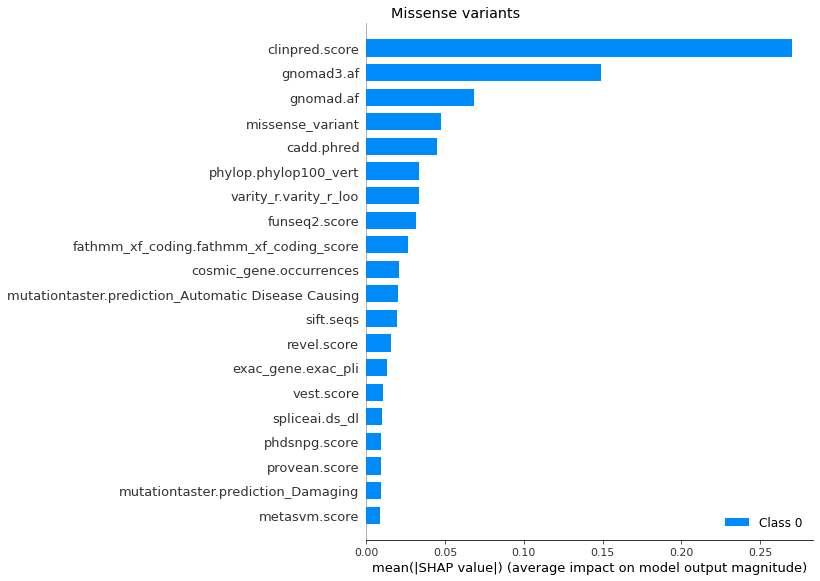

In [128]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)

missense = var1[(var1['so'] =="missense")].drop(config_dict["train_cols"]+extra_cols, axis=1).reset_index(drop=True)
print(missense.shape)
background_x = missense.loc[np.random.choice(missense.shape[0], 50, replace=False)]
shap_values = explainer.shap_values(background_x)
shap.summary_plot(shap_values, background_x, background_x.columns, show=False)
plt.title("Missense variants", x=.2)
plt.show()


In [133]:
conqs = ['missense', 'intergenic', 'splice site', 'intron', 'NMD']


missense variant shape: (4082, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

700/700 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<13:03,  1.57s/it]

704/704 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:03<13:22,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<13:01,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<12:50,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:53,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:09<12:50,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:46,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:46,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:14<12:43,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:47,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:17<12:45,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:45,  1.57s/it]

719/719 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:20<13:03,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:22<12:58,  1.60s/it]

701/701 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:23<12:43,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:25<12:35,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:26<12:26,  1.55s/it]

712/712 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:28<12:44,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:29<12:33,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:31<12:25,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:32<12:18,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:34<12:20,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:35<12:15,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:37<12:10,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:38<12:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:40<12:04,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:42<12:22,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:43<12:11,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:45<12:07,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:46<12:01,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:48<12:03,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:49<11:59,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:51<12:24,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:53<12:16,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:54<12:22,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:56<12:11,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:57<12:03,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:59<11:57,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [01:00<11:52,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:02<12:00,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:03<11:52,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:05<11:51,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:07<11:54,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:08<11:56,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:10<11:52,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:11<11:46,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:13<11:43,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:14<11:45,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:16<11:37,  1.55s/it]

703/703 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:17<11:35,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:19<11:31,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:21<11:43,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:22<11:34,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:24<11:32,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:25<11:37,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:27<11:36,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:28<11:40,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:30<11:36,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:32<11:28,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:33<11:25,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:35<11:17,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:36<11:22,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:38<11:13,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:39<11:25,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:41<11:31,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:43<11:22,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:44<11:14,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:46<11:09,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:47<11:06,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:49<11:10,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:50<11:05,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:52<11:02,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:53<11:06,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:55<11:08,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:57<11:02,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:58<11:06,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [02:00<11:03,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [02:01<11:05,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [02:03<11:07,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:05<11:10,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:06<11:05,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:08<10:57,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:09<10:50,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:11<10:49,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:12<10:56,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:14<11:00,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:15<10:49,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:17<10:43,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:19<10:48,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:20<10:39,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:22<10:32,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:23<10:28,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:25<10:29,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:26<10:26,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:28<10:27,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:29<10:23,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:31<10:31,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:33<10:25,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:34<10:28,  1.57s/it]

700/700 [==============================] - 1s 2ms/step


 20%|██        | 100/500 [02:36<11:13,  1.68s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:38<11:01,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:39<10:48,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:41<10:33,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:42<10:25,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:44<10:21,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:45<10:14,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:47<10:08,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:49<10:14,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:50<10:14,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:52<10:11,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:53<10:08,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:55<10:04,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:56<10:03,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:58<10:00,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:59<09:56,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [03:01<09:53,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [03:03<09:53,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [03:04<09:57,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [03:06<10:00,  1.58s/it]

704/704 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:07<09:56,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:09<10:00,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:10<09:56,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:12<09:49,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:14<09:44,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:15<09:48,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:17<09:41,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:18<09:44,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:20<09:40,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:21<09:37,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:23<09:40,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:24<09:35,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:26<09:31,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:28<09:31,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:29<09:34,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:31<09:26,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:32<09:23,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:34<09:26,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:35<09:21,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:37<09:23,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:39<09:34,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:40<09:30,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:42<09:22,  1.57s/it]

704/704 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:43<09:16,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:45<09:13,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:46<09:11,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:48<09:07,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:49<09:03,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:51<09:04,  1.55s/it]

707/707 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:53<09:16,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:54<09:10,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:56<09:03,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:57<09:00,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:59<08:57,  1.55s/it]

704/704 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [04:00<08:55,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [04:02<08:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [04:03<08:56,  1.56s/it]

703/703 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [04:05<08:53,  1.55s/it]

703/703 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [04:07<08:50,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [04:08<08:45,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:10<08:45,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:11<08:53,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:13<08:48,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:14<08:42,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:16<08:40,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:17<08:36,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:19<08:35,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:20<08:37,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:22<08:37,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:24<08:36,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:25<08:32,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:27<08:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:28<08:27,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:30<08:27,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:31<08:23,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:33<08:27,  1.56s/it]

703/703 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:34<08:25,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:36<08:18,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:38<08:17,  1.54s/it]

716/716 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:39<08:27,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:41<08:23,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:42<08:16,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:44<08:13,  1.55s/it]

704/704 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:45<08:08,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:47<08:13,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:48<08:07,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:50<08:11,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:52<08:13,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:53<08:12,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:55<08:10,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:56<08:09,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:58<08:02,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:59<08:02,  1.57s/it]

703/703 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [05:01<07:56,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [05:03<08:05,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [05:04<08:06,  1.60s/it]

703/703 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [05:06<08:06,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [05:08<08:18,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [05:09<08:09,  1.62s/it]

700/700 [==============================] - 1s 2ms/step


 40%|███▉      | 199/500 [05:11<08:30,  1.70s/it]

701/701 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:13<08:19,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:14<08:17,  1.66s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:16<08:09,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:17<07:57,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:19<07:54,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:21<07:49,  1.59s/it]

702/702 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:22<07:44,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:24<07:39,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:25<07:34,  1.56s/it]

716/716 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:27<07:35,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:28<07:33,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:30<07:37,  1.58s/it]

701/701 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:32<07:39,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:33<07:40,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:35<07:40,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:36<07:30,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:38<07:29,  1.58s/it]

701/701 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:40<07:25,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:41<07:19,  1.56s/it]

703/703 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:43<07:17,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:44<07:13,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:46<07:10,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:47<07:13,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:49<07:15,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:50<07:17,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:52<07:16,  1.59s/it]

701/701 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:54<07:09,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:55<07:05,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:57<07:12,  1.59s/it]

704/704 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:58<07:05,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [06:00<07:01,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [06:01<06:56,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [06:03<06:54,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [06:04<06:53,  1.55s/it]

703/703 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [06:06<06:51,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [06:08<06:46,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [06:09<06:46,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [06:11<06:42,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [06:12<06:40,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:14<06:39,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:15<06:40,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:17<06:36,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:18<06:39,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:20<06:36,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:21<06:34,  1.54s/it]

704/704 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:23<06:31,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:24<06:30,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:26<06:31,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:28<06:32,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:29<06:30,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:31<06:38,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:32<06:34,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:34<06:27,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:35<06:20,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:37<06:28,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:39<06:25,  1.57s/it]

704/704 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:40<06:29,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:42<06:32,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:43<06:25,  1.59s/it]

705/705 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:45<06:25,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:47<06:21,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:48<06:16,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:50<06:16,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:51<06:12,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:53<06:13,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:55<06:13,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:56<06:17,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:58<06:30,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [07:00<06:24,  1.66s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [07:01<06:19,  1.64s/it]

702/702 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [07:03<06:10,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [07:04<06:05,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [07:06<05:58,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [07:07<05:57,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [07:09<05:52,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [07:11<05:52,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [07:12<05:51,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [07:14<05:44,  1.55s/it]

704/704 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [07:15<05:42,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:17<05:41,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:18<05:39,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:20<05:35,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:21<05:36,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:23<05:32,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:24<05:30,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:26<05:33,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:28<05:31,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:29<05:30,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:31<05:41,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:32<05:36,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:34<05:33,  1.59s/it]

702/702 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:35<05:26,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:37<05:20,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:38<05:17,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:40<05:16,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:42<05:14,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:43<05:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:45<05:06,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:46<05:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:48<05:03,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:49<05:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:51<05:03,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:52<04:59,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:54<04:58,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:55<04:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:57<04:53,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:58<04:51,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [08:00<04:52,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [08:01<04:50,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [08:03<04:48,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [08:04<04:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [08:06<04:43,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [08:07<04:42,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [08:09<04:44,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [08:10<04:48,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [08:12<04:44,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [08:13<04:44,  1.55s/it]

704/704 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [08:15<04:41,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [08:16<04:38,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:18<04:37,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:20<04:38,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:21<04:34,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:23<04:32,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:24<04:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:26<04:32,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:27<04:31,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:29<04:27,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:30<04:24,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:32<04:21,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:33<04:19,  1.52s/it]

704/704 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:35<04:17,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:36<04:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:38<04:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:39<04:11,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:41<04:09,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:42<04:09,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:44<04:07,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:45<04:07,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:47<04:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:48<04:07,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:50<04:03,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:51<04:00,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:53<03:59,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:55<04:00,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:56<04:09,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [08:58<04:02,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [08:59<03:59,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [09:01<03:56,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [09:02<03:53,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [09:04<03:57,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [09:06<03:55,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [09:07<03:51,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [09:09<03:47,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [09:10<03:47,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [09:12<03:46,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [09:13<03:44,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [09:15<03:41,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [09:16<03:38,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [09:18<03:35,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:19<03:34,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:21<03:35,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:22<03:33,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:24<03:34,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:26<03:33,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:27<03:29,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:29<03:26,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:30<03:24,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:32<03:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:33<03:22,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:35<03:20,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:36<03:17,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:38<03:16,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:39<03:16,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:41<03:14,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:42<03:11,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:44<03:09,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:45<03:07,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:47<03:08,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:48<03:05,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:50<03:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:51<03:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:53<03:02,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:54<03:00,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:56<02:57,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:57<02:55,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:59<02:53,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [10:01<02:52,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [10:02<02:50,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [10:04<02:48,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [10:05<02:47,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [10:07<02:45,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [10:08<02:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [10:10<02:43,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [10:11<02:42,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [10:13<02:40,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [10:14<02:40,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [10:16<02:39,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [10:17<02:38,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:19<02:35,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:20<02:33,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:22<02:31,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:23<02:29,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:25<02:27,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:26<02:25,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:28<02:25,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:29<02:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:31<02:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:32<02:22,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:34<02:19,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:35<02:18,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:37<02:16,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:38<02:15,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:40<02:12,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:41<02:10,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:43<02:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:45<02:09,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:46<02:07,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:48<02:05,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:49<02:03,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:51<02:02,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:52<02:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:54<01:59,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:55<01:58,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:57<01:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:58<01:54,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [11:00<01:52,  1.50s/it]

703/703 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [11:01<01:51,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [11:03<01:49,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [11:04<01:49,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [11:06<01:47,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [11:07<01:45,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [11:09<01:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [11:10<01:42,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [11:12<01:42,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [11:13<01:39,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [11:15<01:38,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [11:16<01:36,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [11:18<01:35,  1.51s/it]

704/704 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:19<01:33,  1.51s/it]

709/709 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:21<01:33,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:22<01:31,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:24<01:29,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:25<01:27,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:27<01:26,  1.51s/it]

711/711 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:28<01:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:30<01:25,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:32<01:22,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:33<01:20,  1.52s/it]

704/704 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:35<01:18,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:36<01:17,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:38<01:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:39<01:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:41<01:13,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:42<01:13,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:44<01:10,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:45<01:09,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:47<01:08,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:48<01:06,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:50<01:05,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:51<01:02,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:53<01:00,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:54<00:59,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:56<00:57,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:57<00:55,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:59<00:53,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [12:00<00:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [12:02<00:50,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [12:03<00:49,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [12:05<00:48,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [12:06<00:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [12:08<00:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [12:09<00:43,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [12:11<00:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [12:13<00:40,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [12:14<00:38,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [12:15<00:37,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [12:17<00:36,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:19<00:34,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:20<00:33,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:22<00:31,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:23<00:30,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:25<00:28,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:26<00:26,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:28<00:25,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:29<00:23,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:31<00:22,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:32<00:20,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:34<00:19,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:35<00:18,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:37<00:16,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:38<00:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:40<00:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:41<00:12,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:43<00:10,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:44<00:09,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:46<00:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:47<00:06,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:49<00:04,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:50<00:03,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:52<00:01,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:53<00:00,  1.55s/it]


intergenic variant shape: (1240, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

698/698 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<12:23,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:02<12:23,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<12:36,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<12:35,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:26,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:09<12:22,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:17,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:26,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:13<12:24,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:17,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:16<12:12,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:09,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:19<12:14,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:21<12:10,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:22<12:08,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:24<12:04,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:25<12:11,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:27<12:09,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:28<12:04,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:30<12:00,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:31<11:57,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:33<11:55,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:34<11:58,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:36<11:55,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:37<11:53,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:39<11:49,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:40<11:50,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:42<11:46,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:43<11:42,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:45<11:39,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:46<11:37,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:48<11:39,  1.49s/it]

704/704 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:49<11:39,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:51<11:47,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:52<11:49,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:54<11:48,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:55<11:50,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:57<11:52,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [00:58<12:10,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:00<12:16,  1.60s/it]

698/698 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:02<12:29,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:03<12:22,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:05<12:26,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:07<12:22,  1.63s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:08<12:02,  1.59s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:10<11:52,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:11<11:39,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:13<11:37,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:14<11:35,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:16<11:41,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:18<11:50,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:19<11:38,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:21<11:36,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:22<11:26,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:24<11:20,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:25<11:13,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:27<11:08,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:28<11:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:30<11:02,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:31<10:59,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:33<11:02,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:34<10:58,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:36<10:58,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:37<10:55,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:39<11:03,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:40<10:59,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:42<10:54,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:43<10:51,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:45<10:49,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:46<10:44,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:48<10:43,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:49<10:45,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:51<10:52,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:52<10:54,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:54<10:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:55<10:42,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [01:57<10:44,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [01:58<10:41,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [02:00<10:35,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:01<10:41,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:03<10:39,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:04<10:35,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:06<10:32,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:07<10:27,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:09<10:33,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:10<10:27,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:12<10:24,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:14<10:22,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:15<10:18,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:16<10:15,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:18<10:13,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:20<10:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:21<10:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:23<10:16,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:24<10:12,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:26<10:13,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:27<10:09,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:29<10:05,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:30<10:02,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:32<10:00,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:33<10:00,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:35<09:57,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:36<09:54,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:38<09:52,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:39<10:03,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:41<10:05,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:42<09:59,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:44<09:54,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:45<09:50,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:47<09:48,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:48<09:51,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:50<09:55,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:51<09:57,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:53<09:54,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:54<09:50,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:56<09:46,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [02:57<09:41,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [02:59<09:39,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [03:01<09:42,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:02<09:35,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:04<09:33,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:05<09:32,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:07<09:38,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:08<09:33,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:10<09:35,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:11<09:44,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:13<09:37,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:14<09:27,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:16<09:29,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:17<09:23,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:19<09:25,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:20<09:19,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:22<09:16,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:23<09:12,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:25<09:11,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:26<09:09,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:28<09:06,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:29<09:12,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:31<09:13,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:33<09:19,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:34<09:15,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:36<09:09,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:37<09:05,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:39<08:59,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:40<08:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:42<09:00,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:43<08:59,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:45<08:55,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:46<08:53,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:48<08:49,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:49<08:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:51<08:48,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:52<08:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:54<08:40,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:55<08:39,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [03:57<08:41,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [03:58<08:39,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [04:00<08:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [04:01<08:32,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:03<08:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:04<08:30,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:06<08:34,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:07<08:33,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:09<08:36,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:11<08:35,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:12<08:29,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:14<08:25,  1.52s/it]

704/704 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:15<08:22,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:17<08:19,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:18<08:18,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:20<08:15,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:21<08:14,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:23<08:10,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:24<08:10,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:26<08:16,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:27<08:11,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:29<08:12,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:30<08:12,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:32<08:09,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:33<08:05,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:35<08:04,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:36<08:01,  1.51s/it]

700/700 [==============================] - 1s 2ms/step


 37%|███▋      | 183/500 [04:38<08:46,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:40<08:33,  1.62s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:41<08:20,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:43<08:13,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:44<08:07,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:46<08:01,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:47<07:58,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:49<08:00,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:51<07:57,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:52<08:01,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:54<08:21,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:56<08:16,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [04:57<08:03,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [04:59<07:54,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [05:00<07:55,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [05:02<07:57,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [05:03<07:59,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:05<08:07,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:07<08:03,  1.62s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:08<07:57,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:10<08:00,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:11<07:56,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:13<07:46,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:15<07:39,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:16<07:36,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:18<07:31,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:19<07:29,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:21<07:28,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:22<07:36,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:24<07:33,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:25<07:26,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:27<07:27,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:28<07:21,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:30<07:16,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:32<07:13,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:33<07:13,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:35<07:13,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:36<07:08,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:38<07:05,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:39<07:02,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:41<07:02,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:42<06:59,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:44<06:58,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:45<06:54,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:47<06:52,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:48<06:56,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:50<06:53,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:51<06:49,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:53<06:53,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:54<06:48,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [05:56<06:45,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [05:57<06:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [05:59<06:43,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [06:01<06:49,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [06:02<06:44,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [06:04<06:41,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:05<06:40,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:07<06:38,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:08<06:35,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:10<06:37,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:11<06:33,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:13<06:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:14<06:33,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:16<06:29,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:17<06:26,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:19<06:23,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:20<06:26,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:22<06:21,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:23<06:18,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:25<06:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:26<06:14,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:28<06:10,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:30<06:14,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:31<06:12,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:33<06:11,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:34<06:07,  1.52s/it]

709/709 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:36<06:08,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:37<06:05,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:39<06:04,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:40<06:00,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:42<05:58,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:43<05:55,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:45<05:54,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:46<05:51,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:48<05:49,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [06:49<05:47,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [06:51<05:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [06:52<05:45,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [06:54<05:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [06:55<05:43,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [06:57<05:47,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [06:58<05:43,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [07:00<05:40,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [07:01<05:38,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [07:03<05:38,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [07:04<05:34,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:06<05:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:07<05:31,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:09<05:29,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:10<05:30,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:12<05:28,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:13<05:27,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:15<05:25,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:16<05:23,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:18<05:20,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:19<05:20,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:21<05:22,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:23<05:23,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:24<05:19,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:26<05:17,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:27<05:16,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:29<05:12,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:30<05:11,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:32<05:07,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:33<05:07,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:35<05:07,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:36<05:06,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:38<05:03,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:39<05:01,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:41<05:00,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:42<04:59,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:44<04:56,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:45<04:54,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:47<04:52,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [07:48<04:50,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [07:50<04:50,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [07:51<04:54,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [07:53<04:52,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [07:54<04:49,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [07:56<04:46,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [07:57<04:47,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [07:59<04:45,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [08:01<04:42,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [08:02<04:38,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [08:04<04:36,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [08:05<04:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:07<04:32,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:08<04:29,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:10<04:28,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:11<04:28,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:13<04:27,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:14<04:24,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:16<04:23,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:17<04:21,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:19<04:19,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:20<04:17,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:22<04:18,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:23<04:19,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:25<04:16,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:26<04:13,  1.51s/it]

703/703 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:28<04:14,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:29<04:10,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:31<04:08,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:32<04:06,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:34<04:05,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:35<04:03,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:37<04:01,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:38<03:59,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:40<03:58,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:41<03:57,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:43<03:56,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:44<03:53,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [08:46<03:52,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [08:47<03:51,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [08:49<03:54,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [08:50<03:51,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [08:52<03:50,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [08:53<03:46,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [08:55<03:43,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [08:56<03:41,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [08:58<03:48,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [08:59<03:43,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [09:01<03:40,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [09:02<03:37,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [09:04<03:37,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [09:05<03:34,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:07<03:32,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:08<03:29,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:10<03:29,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:11<03:26,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:13<03:28,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:14<03:26,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:16<03:24,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:18<03:23,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:19<03:21,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:21<03:19,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:22<03:18,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:24<03:15,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:25<03:14,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:27<03:12,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:28<03:10,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:30<03:09,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:31<03:11,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:33<03:08,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:34<03:05,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:36<03:03,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:37<03:03,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:39<03:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:40<03:01,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:42<02:58,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:43<02:57,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:45<02:57,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:46<02:54,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [09:48<02:54,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [09:49<02:52,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [09:51<02:49,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [09:52<02:46,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [09:54<02:45,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [09:55<02:44,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [09:57<02:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [09:58<02:40,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [10:00<02:39,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [10:01<02:37,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [10:03<02:37,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [10:04<02:35,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:06<02:33,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:07<02:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:09<02:32,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:10<02:30,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:12<02:28,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:14<02:27,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:15<02:25,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:17<02:25,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:18<02:23,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:20<02:20,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:21<02:18,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:23<02:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:24<02:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:26<02:14,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:27<02:13,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:29<02:11,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:30<02:11,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:32<02:09,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:33<02:07,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:35<02:05,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:36<02:03,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:38<02:01,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:39<02:00,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:41<01:59,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:42<01:57,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:44<01:56,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:45<01:55,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [10:47<01:53,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [10:48<01:51,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [10:50<01:49,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [10:51<01:48,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [10:53<01:51,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [10:55<01:48,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [10:56<01:47,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [10:58<01:45,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [10:59<01:42,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [11:01<01:40,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [11:02<01:39,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [11:04<01:37,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [11:05<01:35,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:07<01:34,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:08<01:32,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:10<01:31,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:11<01:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:13<01:29,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:14<01:27,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:16<01:25,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:17<01:23,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:19<01:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:20<01:20,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:22<01:18,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:23<01:16,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:25<01:15,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:26<01:13,  1.51s/it]

707/707 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:28<01:12,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:30<01:11,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:31<01:09,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:33<01:08,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:34<01:06,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:36<01:04,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:37<01:03,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:39<01:01,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:40<01:00,  1.51s/it]

703/703 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:42<00:58,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:43<00:57,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:45<00:55,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:46<00:54,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [11:48<00:52,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [11:49<00:51,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [11:51<00:50,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [11:52<00:49,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [11:54<00:47,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [11:55<00:45,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [11:57<00:44,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [11:58<00:42,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [12:00<00:40,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [12:01<00:39,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [12:03<00:37,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [12:04<00:36,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:06<00:35,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:07<00:33,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:09<00:31,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:10<00:30,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:12<00:28,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:13<00:27,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:15<00:25,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:16<00:24,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:18<00:22,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:20<00:21,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:21<00:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:23<00:18,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:24<00:16,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:26<00:15,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:27<00:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:29<00:12,  1.50s/it]

704/704 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:30<00:10,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:32<00:09,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:33<00:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:35<00:06,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:36<00:04,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:38<00:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:39<00:01,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:41<00:00,  1.52s/it]


splice site variant shape: (954, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

700/700 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<12:24,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:03<12:28,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<12:30,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<12:40,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:33,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:09<12:30,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:26,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:32,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:13<12:33,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:25,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:16<12:21,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:21,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:19<12:18,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:21<12:23,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:22<12:20,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:24<12:36,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:25<12:25,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:27<12:21,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:29<12:14,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:30<12:08,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:32<12:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:33<12:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:35<12:10,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:36<12:15,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:38<12:17,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:39<12:17,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:41<12:20,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:42<12:10,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:44<12:06,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:45<12:00,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:47<11:54,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:48<11:48,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:50<11:51,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:51<11:48,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:53<11:46,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:55<11:44,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:56<11:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:58<11:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [00:59<11:38,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:01<11:36,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:02<11:33,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:04<11:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:05<11:31,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:07<11:27,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:08<11:27,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:10<11:23,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:11<11:23,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:13<11:24,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:14<11:20,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:16<11:20,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:17<11:21,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:19<11:24,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:20<11:27,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:22<11:23,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:23<11:25,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:25<11:19,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:26<11:27,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:28<11:19,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:30<11:15,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:31<11:15,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:33<11:18,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:34<11:12,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:36<11:20,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:37<11:11,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:39<11:04,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:40<11:03,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:42<10:58,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:43<10:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:45<10:59,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:46<11:04,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:48<11:04,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:50<11:12,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:51<11:11,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:53<11:01,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:54<10:55,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:56<10:50,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [01:57<10:52,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [01:59<10:46,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [02:00<10:52,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:02<10:44,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:03<10:49,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:05<10:45,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:06<10:38,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:08<10:34,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:10<10:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:11<10:30,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:13<10:32,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:14<10:31,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:16<10:32,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:17<10:29,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:19<10:25,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:20<10:21,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:22<10:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:24<11:01,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:25<10:53,  1.61s/it]

702/702 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:27<10:39,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:28<10:31,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:30<10:31,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:31<10:21,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:33<10:24,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:34<10:16,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:36<10:11,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:37<10:05,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:39<10:06,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:41<10:12,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:42<10:16,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:44<10:11,  1.56s/it]

703/703 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:45<10:09,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:47<10:08,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:48<10:09,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:50<10:03,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:51<09:57,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:53<09:51,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:54<09:48,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:56<09:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:58<09:44,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [02:59<09:41,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [03:01<09:40,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [03:02<09:39,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:04<09:36,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:05<09:33,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:07<09:37,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:08<09:36,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:10<09:33,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:11<09:28,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:13<09:28,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:14<09:34,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:16<09:31,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:17<09:26,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:19<09:21,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:20<09:27,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:22<09:20,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:23<09:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:25<09:24,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:27<09:17,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:28<09:13,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:30<09:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:31<09:16,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:33<09:10,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:34<09:05,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:36<09:09,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:37<09:15,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:39<09:08,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:40<09:11,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:42<09:11,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:43<09:08,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:45<09:03,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:47<09:05,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:48<08:58,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:50<08:56,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:51<08:50,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:53<08:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:54<08:45,  1.51s/it]

704/704 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:56<08:43,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:57<08:40,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [03:59<08:38,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [04:00<08:38,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [04:02<08:39,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [04:03<08:35,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:05<08:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:06<08:39,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:08<08:35,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:09<08:30,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:11<08:36,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:12<08:30,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:14<08:28,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:15<08:26,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:17<08:24,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:18<08:21,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:20<08:18,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:21<08:18,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:23<08:14,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:24<08:11,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:26<08:12,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:27<08:10,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:29<08:09,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:30<08:09,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:32<08:07,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:33<08:03,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:35<07:59,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:36<08:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:38<07:58,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:40<08:02,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:41<08:03,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:43<08:01,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:44<07:57,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:46<07:55,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:47<07:55,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:49<07:56,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:50<07:59,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:52<07:55,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:53<07:56,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:55<07:50,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:56<07:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [04:58<07:49,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [04:59<07:45,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [05:01<07:40,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [05:02<07:36,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [05:04<07:37,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:06<07:40,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:07<07:40,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:09<07:36,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:10<07:34,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:12<07:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:13<07:24,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:15<07:23,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:16<07:22,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:18<07:21,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:19<07:25,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:21<07:21,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:22<07:17,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:24<07:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:25<07:23,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:27<07:17,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:28<07:12,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:30<07:16,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:31<07:14,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:33<07:10,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:34<07:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:36<07:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:38<07:04,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:39<07:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:41<06:59,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:42<06:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:44<06:58,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:45<06:57,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:47<06:52,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:48<06:50,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:50<06:51,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:51<06:49,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:53<06:46,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:54<06:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [05:56<06:52,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [05:57<06:47,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [05:59<06:47,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [06:00<06:45,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [06:02<06:45,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [06:03<06:40,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:05<06:40,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:07<06:44,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:08<06:38,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:10<06:33,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:11<06:32,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:13<06:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:14<06:30,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:16<06:26,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:17<06:27,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:19<06:24,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:20<06:25,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:22<06:36,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:24<06:33,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:25<06:33,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:27<06:40,  1.62s/it]

702/702 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:28<06:40,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:30<06:34,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:32<06:36,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:33<06:35,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:35<06:33,  1.63s/it]

702/702 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:36<06:22,  1.59s/it]

702/702 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:38<06:15,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:40<06:11,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:41<06:06,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:43<06:01,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:44<06:03,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:46<05:58,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:47<05:55,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:49<05:54,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [06:50<05:51,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [06:52<05:48,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [06:53<05:50,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [06:55<05:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [06:56<05:44,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [06:58<05:43,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [06:59<05:41,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [07:01<05:39,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [07:02<05:40,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [07:04<05:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [07:05<05:36,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:07<05:35,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:08<05:33,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:10<05:34,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:11<05:37,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:13<05:33,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:14<05:30,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:16<05:28,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:18<05:29,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:19<05:30,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:21<05:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:22<05:26,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:24<05:25,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:25<05:20,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:27<05:17,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:28<05:20,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:30<05:24,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:32<05:25,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:33<05:18,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:35<05:12,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:36<05:14,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:38<05:09,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:39<05:10,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:41<05:06,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:42<05:03,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:44<05:01,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:45<04:57,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:47<04:56,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:48<04:54,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [07:50<04:51,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [07:51<04:49,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [07:53<04:50,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [07:54<04:50,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [07:56<04:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [07:58<04:52,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [07:59<04:48,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [08:01<04:44,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [08:02<04:43,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [08:04<04:39,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [08:05<04:36,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [08:07<04:35,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:08<04:36,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:10<04:37,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:11<04:33,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:13<04:30,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:14<04:30,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:16<04:27,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:17<04:24,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:19<04:27,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:20<04:23,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:22<04:22,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:23<04:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:25<04:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:26<04:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:28<04:17,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:30<04:19,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:31<04:15,  1.54s/it]

703/703 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:33<04:11,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:34<04:10,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:36<04:07,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:37<04:06,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:39<04:03,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:40<04:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:42<03:59,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:43<04:01,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:45<03:58,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:46<03:56,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [08:48<03:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [08:49<03:55,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [08:51<03:53,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [08:52<03:50,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [08:54<03:49,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [08:56<03:50,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [08:57<03:48,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [08:59<03:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [09:00<03:45,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [09:02<03:43,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [09:03<03:40,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [09:05<03:38,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [09:06<03:35,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [09:08<03:34,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:09<03:33,  1.51s/it]

704/704 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:11<03:31,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:12<03:28,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:14<03:30,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:15<03:28,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:17<03:26,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:18<03:25,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:20<03:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:21<03:25,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:23<03:21,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:24<03:19,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:26<03:18,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:27<03:15,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:29<03:16,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:31<03:14,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:32<03:14,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:34<03:12,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:35<03:09,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:37<03:09,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:38<03:07,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:40<03:07,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:41<03:05,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:43<03:01,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:44<03:01,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:46<03:01,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:48<02:59,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:49<02:58,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [09:51<02:58,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [09:52<02:54,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [09:54<02:51,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [09:55<02:49,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [09:57<02:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [09:58<02:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [10:00<02:43,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [10:01<02:42,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [10:03<02:41,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [10:04<02:38,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [10:06<02:40,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [10:07<02:39,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:09<02:39,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:11<02:36,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:12<02:33,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:14<02:32,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:15<02:31,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:17<02:33,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:18<02:31,  1.58s/it]

701/701 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:20<02:27,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:21<02:24,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:23<02:22,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:24<02:22,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:26<02:20,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:28<02:19,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:29<02:16,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:31<02:17,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:32<02:16,  1.56s/it]

702/702 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:34<02:13,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:35<02:11,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:37<02:09,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:39<02:09,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:40<02:08,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:42<02:07,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:43<02:06,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:45<02:03,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:46<02:01,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:48<01:59,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:49<01:57,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [10:51<01:57,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [10:53<01:55,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [10:54<01:54,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [10:56<01:53,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [10:57<01:51,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [10:59<01:49,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [11:00<01:48,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [11:02<01:46,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [11:04<01:45,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [11:05<01:42,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [11:07<01:40,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [11:08<01:39,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [11:10<01:39,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:11<01:37,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:13<01:35,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:14<01:33,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:16<01:31,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:18<01:30,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:19<01:28,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:21<01:28,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:22<01:25,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:24<01:23,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:25<01:21,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:27<01:19,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:28<01:17,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:30<01:17,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:31<01:15,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:33<01:13,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:35<01:11,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:36<01:10,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:38<01:09,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:39<01:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:41<01:06,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:42<01:04,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:44<01:03,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:45<01:01,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:47<01:01,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:48<00:58,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:50<00:57,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:52<00:55,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [11:53<00:53,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [11:55<00:52,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [11:56<00:50,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [11:58<00:49,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [11:59<00:47,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [12:01<00:46,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [12:02<00:45,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [12:04<00:43,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [12:06<00:42,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [12:07<00:40,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [12:09<00:39,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [12:10<00:37,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:12<00:36,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:13<00:34,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:15<00:32,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:16<00:30,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:18<00:29,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:19<00:27,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:21<00:26,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:23<00:24,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:24<00:23,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:26<00:21,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:27<00:19,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:29<00:18,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:30<00:16,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:32<00:15,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:33<00:13,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:35<00:12,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:36<00:10,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:38<00:09,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:39<00:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:41<00:06,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:42<00:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:44<00:03,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:46<00:01,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:47<00:00,  1.54s/it]


intron variant shape: (7416, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

699/699 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<12:48,  1.54s/it]

697/697 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:03<13:08,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<12:52,  1.55s/it]

697/697 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<12:46,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:38,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:09<12:38,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:32,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:34,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:13<12:40,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:37,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:16<12:31,  1.54s/it]

697/697 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:32,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:20<12:25,  1.53s/it]

697/697 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:21<12:23,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:23<12:18,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:24<12:18,  1.53s/it]

697/697 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:26<12:15,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:27<12:13,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:29<12:13,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:30<12:10,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:32<12:03,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:33<12:05,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:35<11:59,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:36<12:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:38<12:06,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:39<12:05,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:41<12:01,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:42<12:01,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:44<12:02,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:45<12:03,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:47<11:58,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:48<11:51,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:50<11:43,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:51<11:46,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:53<11:39,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:54<11:33,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:56<11:36,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:57<11:31,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [00:59<11:26,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:00<11:28,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:02<11:25,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:03<11:29,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:05<11:25,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:06<11:22,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:08<11:21,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:09<11:25,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:11<11:17,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:12<11:18,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:14<11:14,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:15<11:18,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:17<11:12,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:18<11:08,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:20<11:07,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:21<11:04,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:23<11:04,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:24<11:02,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:26<10:59,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:27<10:59,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:29<10:57,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:30<10:52,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:32<10:52,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:33<10:50,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:35<10:54,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:36<10:48,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:38<10:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:39<10:49,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:41<10:45,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:42<10:43,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:44<10:39,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:45<10:43,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:47<10:41,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:48<10:36,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:50<10:34,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:51<10:42,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:53<10:35,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:54<10:33,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [01:56<10:30,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [01:57<10:29,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [01:59<10:37,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:00<10:30,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:02<10:26,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:03<10:23,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:05<10:23,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:06<10:19,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:08<10:16,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:09<10:28,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:11<10:23,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:12<10:30,  1.53s/it]

697/697 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:14<10:20,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:15<10:14,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:17<10:14,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:18<10:06,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:20<10:02,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:21<10:03,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:23<10:01,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:24<10:03,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:26<10:02,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:27<09:58,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:29<09:59,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:30<09:54,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:32<09:59,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:33<09:53,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:35<09:51,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:36<09:52,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:38<09:49,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:39<09:48,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:41<09:46,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:42<09:46,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:44<09:43,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:45<09:42,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:47<09:41,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:48<09:37,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:50<09:34,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:51<09:35,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:52<09:33,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:54<09:31,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [02:55<09:33,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [02:57<09:30,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [02:58<09:31,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:00<09:31,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:01<09:26,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:03<09:30,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:04<09:24,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:06<09:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:08<09:22,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:09<09:21,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:11<09:19,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:12<09:16,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:13<09:15,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:15<09:12,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:16<09:11,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:18<09:12,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:19<09:10,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:21<09:06,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:22<09:06,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:24<09:03,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:25<09:03,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:27<09:00,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:28<08:58,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:30<09:00,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:31<08:56,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:33<08:55,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:34<08:52,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:36<08:51,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:37<08:51,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:39<08:47,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:40<08:44,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:42<08:46,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:43<08:44,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:45<08:46,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:46<08:41,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:48<08:41,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:49<08:38,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:51<08:43,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:52<08:41,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [03:54<08:37,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [03:55<08:38,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [03:57<08:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [03:58<08:33,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:00<08:31,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:01<08:27,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:03<08:27,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:04<08:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:06<08:26,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:07<08:25,  1.51s/it]

697/697 [==============================] - 1s 2ms/step


 33%|███▎      | 166/500 [04:09<08:58,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:11<08:45,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:12<08:37,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:14<08:30,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:15<08:25,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:17<08:18,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:18<08:17,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:20<08:17,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:21<08:12,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:23<08:11,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:24<08:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:26<08:04,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:27<08:04,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:29<08:00,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:30<08:00,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:32<07:57,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:33<07:56,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:35<07:56,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:36<07:54,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:38<07:53,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:39<07:50,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:41<07:47,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:42<07:48,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:44<07:45,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:45<07:45,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:47<07:49,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:48<07:47,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:50<07:45,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:51<07:43,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [04:53<07:56,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [04:55<07:50,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [04:56<07:44,  1.53s/it]

697/697 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [04:58<07:42,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [04:59<07:36,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:01<07:33,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:02<07:32,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:04<07:28,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:05<07:25,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:07<07:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:08<07:22,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:10<07:21,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:11<07:18,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:13<07:19,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:14<07:18,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:16<07:15,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:17<07:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:19<07:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:20<07:12,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:22<07:09,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:23<07:07,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:25<07:04,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:26<07:02,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:28<07:06,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:29<07:03,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:31<07:04,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:32<07:00,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:34<06:56,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:35<06:55,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:37<06:52,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:38<06:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:40<06:49,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:41<06:50,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:43<06:48,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:44<06:44,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:46<06:45,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:47<06:42,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:49<06:41,  1.50s/it]

704/704 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [05:50<06:42,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [05:52<06:40,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [05:53<06:38,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [05:55<06:35,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [05:56<06:34,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [05:58<06:33,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [05:59<06:30,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:01<06:29,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:02<06:25,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:04<06:26,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:05<06:24,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:07<06:23,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:08<06:21,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:10<06:20,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:11<06:19,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:13<06:17,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:14<06:14,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:16<06:15,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:17<06:12,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:19<06:09,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:20<06:09,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:22<06:05,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:23<06:06,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:25<06:05,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:26<06:04,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:28<06:01,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:29<05:59,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:31<05:59,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:32<05:57,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:34<05:56,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:35<05:54,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:37<05:51,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:38<05:51,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:40<05:49,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:41<05:49,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [06:43<05:46,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [06:44<05:44,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [06:46<05:43,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [06:47<05:40,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [06:49<05:41,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [06:50<05:39,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [06:52<05:38,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [06:53<05:37,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [06:55<05:33,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [06:56<05:34,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [06:58<05:32,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [06:59<05:29,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:01<05:29,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:02<05:26,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:04<05:27,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:05<05:23,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:06<05:21,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:08<05:21,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:09<05:18,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:11<05:18,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:12<05:16,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:14<05:14,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:15<05:14,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:17<05:11,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:18<05:11,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:20<05:09,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:21<05:07,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:23<05:06,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:24<05:05,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:26<05:04,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:27<05:02,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:29<05:00,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:30<05:00,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:32<04:58,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:33<04:56,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:35<04:56,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:36<04:53,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:38<04:52,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:39<04:50,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [07:41<04:47,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [07:42<04:46,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [07:44<04:44,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [07:45<04:43,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [07:47<04:41,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [07:48<04:41,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [07:50<04:38,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [07:51<04:37,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [07:53<04:35,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [07:54<04:34,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [07:56<04:34,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [07:57<04:32,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [07:59<04:31,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:00<04:29,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:02<04:30,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:03<04:28,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:05<04:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:06<04:24,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:08<04:22,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:09<04:19,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:11<04:19,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:12<04:16,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:14<04:15,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:15<04:17,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:17<04:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:18<04:12,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:20<04:09,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:21<04:09,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:23<04:06,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:24<04:12,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:26<04:07,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:28<04:08,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:29<04:04,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:30<04:01,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:32<03:59,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:33<03:57,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:35<03:55,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:36<03:53,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [08:38<03:51,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [08:39<03:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [08:41<03:49,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [08:42<03:48,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [08:44<03:46,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [08:45<03:44,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [08:47<03:43,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [08:48<03:41,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [08:50<03:41,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [08:51<03:38,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [08:53<03:35,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [08:54<03:35,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [08:56<03:32,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [08:57<03:32,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [08:59<03:29,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:00<03:28,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:02<03:27,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:03<03:25,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:05<03:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:06<03:23,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:08<03:22,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:09<03:21,  1.51s/it]

710/710 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:11<03:25,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:13<03:21,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:14<03:18,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:16<03:15,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:17<03:14,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:18<03:11,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:20<03:10,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:22<03:09,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:23<03:06,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:25<03:06,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:26<03:04,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:27<03:02,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:29<03:01,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:30<02:59,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:32<02:59,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:34<02:57,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:35<02:55,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:36<02:53,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:38<02:52,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [09:40<02:51,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [09:41<02:49,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [09:42<02:47,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [09:44<02:45,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [09:45<02:44,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [09:47<02:42,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [09:48<02:41,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [09:50<02:39,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [09:51<02:38,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [09:53<02:36,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [09:54<02:35,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [09:56<02:34,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [09:57<02:32,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [09:59<02:30,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:00<02:29,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:02<02:27,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:03<02:27,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:05<02:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:06<02:23,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:08<02:22,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:09<02:21,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:11<02:18,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:12<02:18,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:14<02:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:15<02:14,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:17<02:13,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:18<02:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:20<02:11,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:22<02:15,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:23<02:11,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:25<02:09,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:26<02:06,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:28<02:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:29<02:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:31<02:01,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:32<01:59,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:34<01:57,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:35<01:55,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:37<01:54,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [10:38<01:52,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [10:40<01:51,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [10:41<01:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [10:43<01:48,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [10:44<01:46,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [10:46<01:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [10:47<01:43,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [10:49<01:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [10:50<01:40,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [10:52<01:38,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [10:53<01:37,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [10:55<01:35,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [10:56<01:33,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [10:58<01:32,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [10:59<01:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:01<01:29,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:02<01:29,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:04<01:27,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:05<01:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:07<01:24,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:08<01:23,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:10<01:20,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:11<01:19,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:13<01:17,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:14<01:16,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:16<01:14,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:17<01:13,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:19<01:11,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:20<01:10,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:22<01:08,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:23<01:07,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:25<01:06,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:26<01:05,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:28<01:03,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:29<01:02,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:31<01:01,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:32<00:59,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:34<00:57,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:35<00:55,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:37<00:54,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [11:38<00:52,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [11:40<00:51,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [11:41<00:50,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [11:43<00:48,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [11:44<00:47,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [11:46<00:45,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [11:47<00:43,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [11:49<00:42,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [11:50<00:40,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [11:52<00:39,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [11:54<00:37,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [11:55<00:36,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [11:57<00:34,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [11:58<00:33,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:00<00:31,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:01<00:30,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:03<00:28,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:04<00:27,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:06<00:25,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:07<00:24,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:09<00:22,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:10<00:20,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:12<00:19,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:13<00:17,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:15<00:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:16<00:15,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:18<00:13,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:19<00:12,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:21<00:10,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:22<00:09,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:24<00:07,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:25<00:06,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:27<00:04,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:28<00:03,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:30<00:01,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:31<00:00,  1.50s/it]


NMD variant shape: (3415, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

699/699 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<12:42,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:03<12:27,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<12:32,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<12:28,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:28,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:09<12:21,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:17,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:18,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:13<12:13,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:23,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:16<12:25,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:19<12:15,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:21<12:12,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:22<12:08,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:24<12:05,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:25<12:01,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:27<11:58,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:28<11:57,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:30<11:54,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:31<11:55,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:33<11:54,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:34<11:49,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:36<11:48,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:37<11:52,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:39<11:48,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:40<11:43,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:41<11:45,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:43<11:46,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:45<11:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:46<11:40,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:47<11:37,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:49<11:37,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:50<11:33,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:52<11:33,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:53<11:32,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:55<11:31,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:56<11:36,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [00:58<11:34,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:00<11:41,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:01<11:49,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:03<11:37,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:04<11:44,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:06<11:35,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:07<11:34,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:09<11:25,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:10<11:23,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:12<11:18,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:13<11:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:15<11:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:16<11:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:18<11:12,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:19<11:15,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:21<11:11,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:22<11:06,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:24<11:06,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:25<11:04,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:27<11:00,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:28<11:11,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:30<11:07,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:31<11:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:33<11:00,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:34<10:56,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:36<10:52,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:37<10:52,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:39<10:56,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:40<10:51,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:42<10:49,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:43<10:47,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:45<10:43,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:46<10:44,  1.50s/it]

713/713 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:48<10:59,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:49<10:52,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:51<10:48,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:52<10:42,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:54<10:38,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [01:55<10:33,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [01:57<10:38,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [01:58<10:33,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:00<10:36,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:01<10:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:03<10:33,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:04<10:29,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:06<10:30,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:07<10:26,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:09<10:28,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:11<10:23,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:12<10:34,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:14<10:24,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:15<10:23,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:17<10:18,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:18<10:14,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:20<10:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:21<10:10,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:23<10:05,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:24<10:08,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:26<10:05,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:27<10:04,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:29<10:05,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:30<10:11,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:32<10:09,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:33<10:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:35<09:59,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:36<09:57,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:38<09:57,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:39<09:52,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:41<09:54,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:42<09:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:44<09:48,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:45<09:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:47<09:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:48<09:40,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:50<09:44,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:51<09:42,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:53<09:48,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:54<09:45,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [02:56<09:39,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [02:57<09:34,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [02:59<09:36,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:00<09:32,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:02<09:32,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:03<09:28,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:05<09:25,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:06<09:27,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:08<09:24,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:09<09:23,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:11<09:21,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:12<09:19,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:14<09:19,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:15<09:17,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:17<09:15,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:18<09:16,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:20<09:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:21<09:08,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:23<09:07,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:24<09:05,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:26<09:03,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:27<09:04,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:29<09:02,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:30<09:00,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:32<09:03,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:33<08:58,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:35<08:57,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:37<08:59,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:38<08:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:40<09:03,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:41<08:57,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:43<08:51,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:44<08:52,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:46<08:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:47<08:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:49<08:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:50<08:44,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:52<08:39,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:53<08:39,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [03:55<08:38,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [03:56<08:44,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [03:58<08:42,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [03:59<08:38,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:01<08:33,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:02<08:33,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:04<08:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:05<08:24,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:07<08:26,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:08<08:24,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:10<08:21,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:11<08:23,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:13<08:20,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:14<08:22,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:16<08:18,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:17<08:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:19<08:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:20<08:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:22<08:10,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:23<08:12,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:25<08:10,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:26<08:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:28<08:06,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:29<08:02,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:31<08:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:32<07:58,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:34<07:56,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:35<07:55,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:37<07:53,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:38<07:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:40<07:51,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:41<07:50,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:43<07:46,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:44<07:55,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:46<07:49,  1.51s/it]

699/699 [==============================] - 1s 2ms/step


 38%|███▊      | 191/500 [04:48<08:27,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:49<08:12,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:51<08:01,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:52<07:51,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [04:54<07:46,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [04:55<07:42,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [04:57<07:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [04:58<07:36,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [05:00<07:36,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:01<07:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:03<07:33,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:04<07:30,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:06<07:29,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:07<07:29,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:09<07:26,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:10<07:22,  1.51s/it]

703/703 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:12<07:22,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:13<07:17,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:15<07:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:17<07:17,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:18<07:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:20<07:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:21<07:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:23<07:16,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:24<07:13,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:26<07:10,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:27<07:08,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:29<07:05,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:30<07:10,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:32<07:06,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:33<07:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:35<07:01,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:36<06:58,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:38<06:55,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:39<06:55,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:41<06:53,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:42<06:52,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:44<06:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:45<06:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:47<06:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:48<06:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:50<06:42,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [05:51<06:40,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [05:53<06:39,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [05:54<06:37,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [05:56<06:36,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [05:57<06:35,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [05:59<06:32,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:00<06:30,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:02<06:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:03<06:30,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:05<06:27,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:06<06:32,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:08<06:28,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:09<06:24,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:11<06:23,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:12<06:20,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:14<06:17,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:15<06:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:17<06:16,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:18<06:20,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:20<06:16,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:21<06:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:23<06:11,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:24<06:09,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:26<06:06,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:27<06:05,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:29<06:09,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:31<06:05,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:32<06:00,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:34<06:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:35<06:03,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:37<05:58,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:38<05:58,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:40<05:55,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:41<05:52,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:43<05:53,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [06:44<05:49,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [06:46<05:46,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [06:47<05:45,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [06:49<05:42,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [06:50<05:39,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [06:52<05:39,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [06:53<05:37,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [06:55<05:35,  1.49s/it]

703/703 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [06:56<05:35,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [06:58<05:34,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [06:59<05:31,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:01<05:31,  1.50s/it]

703/703 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:02<05:29,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:04<05:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:05<05:26,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:07<05:26,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:08<05:24,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:10<05:23,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:11<05:20,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:13<05:18,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:14<05:18,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:16<05:16,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:17<05:18,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:19<05:17,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:20<05:14,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:22<05:10,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:23<05:10,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:25<05:08,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:26<05:05,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:28<05:05,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:29<05:02,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:31<05:05,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:32<05:05,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:34<05:01,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:35<05:01,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:37<04:58,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:38<04:54,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:40<04:51,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:41<04:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [07:43<04:49,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [07:44<04:48,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [07:46<04:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [07:47<04:45,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [07:49<04:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [07:50<04:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [07:52<04:39,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [07:53<04:38,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [07:55<04:37,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [07:56<04:35,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [07:58<04:34,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [07:59<04:33,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:01<04:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:02<04:29,  1.50s/it]

706/706 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:04<04:36,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:05<04:31,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:07<04:31,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:08<04:29,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:10<04:25,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:11<04:25,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:13<04:21,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:14<04:18,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:16<04:20,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:17<04:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:19<04:14,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:20<04:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:22<04:14,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:24<04:11,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:25<04:13,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:27<04:12,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:28<04:08,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:30<04:06,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:31<04:04,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:33<04:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:34<04:00,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:36<03:57,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:37<03:54,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:39<03:53,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [08:40<03:51,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [08:42<03:50,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [08:43<03:49,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [08:45<03:47,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [08:46<03:46,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [08:48<03:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [08:49<03:42,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [08:51<03:41,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [08:52<03:39,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [08:54<03:37,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [08:55<03:36,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [08:57<03:36,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [08:58<03:35,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [09:00<03:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:01<03:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:03<03:30,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:04<03:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:06<03:26,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:07<03:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:09<03:23,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:10<03:22,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:12<03:22,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:13<03:20,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:15<03:18,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:16<03:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:18<03:15,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:19<03:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:21<03:11,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:22<03:09,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:24<03:11,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:25<03:08,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:27<03:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:28<03:04,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:30<03:02,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:31<03:01,  1.50s/it]

719/719 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:33<03:02,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:34<03:00,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:36<02:58,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:37<02:55,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:39<02:55,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:40<02:53,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [09:42<02:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [09:43<02:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [09:45<02:47,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [09:46<02:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [09:48<02:45,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [09:49<02:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [09:51<02:42,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [09:52<02:41,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [09:54<02:39,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [09:55<02:37,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [09:57<02:39,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [09:58<02:36,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:00<02:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:01<02:32,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:03<02:30,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:04<02:27,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:06<02:27,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:07<02:25,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:09<02:25,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:10<02:23,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:12<02:21,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:13<02:20,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:15<02:17,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:16<02:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:18<02:15,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:19<02:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:21<02:11,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:22<02:10,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:24<02:10,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:26<02:08,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:27<02:06,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:29<02:05,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:30<02:03,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:32<02:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:33<02:00,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:35<01:59,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:36<01:57,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:38<01:57,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:39<01:55,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [10:41<01:53,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [10:42<01:52,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [10:44<01:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [10:45<01:48,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [10:47<01:46,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [10:48<01:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [10:50<01:43,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [10:51<01:43,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [10:53<01:41,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [10:54<01:39,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [10:56<01:37,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [10:57<01:36,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [10:59<01:39,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:00<01:36,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:02<01:34,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:04<01:32,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:05<01:32,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:07<01:29,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:08<01:27,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:10<01:25,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:11<01:23,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:13<01:22,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:14<01:20,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:16<01:18,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:17<01:17,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:19<01:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:20<01:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:22<01:12,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:23<01:11,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:25<01:09,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:26<01:08,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:28<01:06,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:29<01:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:31<01:03,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:32<01:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:34<01:00,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:35<00:58,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:37<00:57,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:38<00:55,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:40<00:54,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [11:41<00:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [11:43<00:51,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [11:44<00:50,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [11:46<00:48,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [11:47<00:47,  1.52s/it]

725/725 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [11:49<00:47,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [11:51<00:44,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [11:52<00:43,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [11:54<00:41,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [11:55<00:40,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [11:57<00:38,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [11:58<00:36,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:00<00:35,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:01<00:33,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:03<00:31,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:04<00:30,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:06<00:28,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:07<00:27,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:09<00:25,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:10<00:24,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:12<00:22,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:13<00:21,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:15<00:19,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:16<00:18,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:18<00:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:19<00:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:21<00:13,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:23<00:12,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:24<00:10,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:26<00:09,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:27<00:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:29<00:06,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:30<00:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:32<00:03,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:33<00:01,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:35<00:00,  1.51s/it]


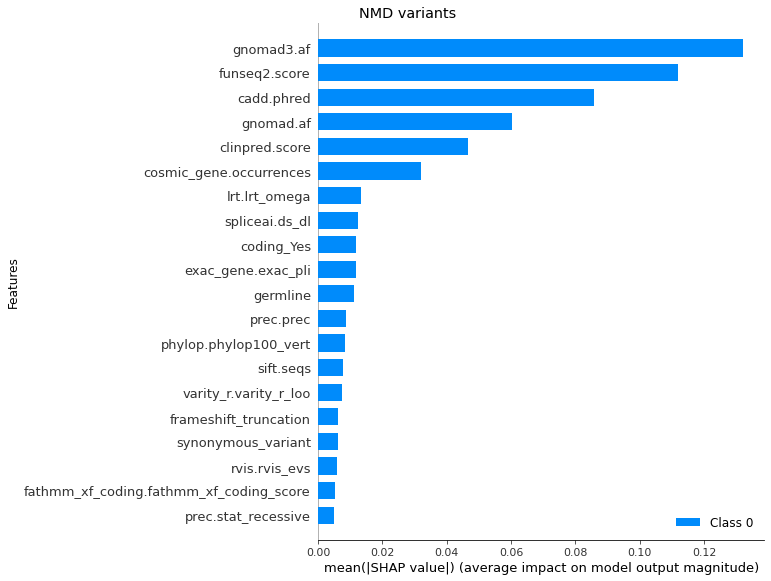

In [136]:
for so in conqs:
    plt.clf()
    #plt.suptitle("Benchmarking damage prediction tools", fontsize=10)
    plt.xlabel("mean SHAP value")
    plt.ylabel("Features")
    plt.title(f"SHAP plot for {so}")

    missense = var1[(var1['so'] ==so)].drop(config_dict["train_cols"]+extra_cols, axis=1).reset_index(drop=True)
    print(f"{so} variant shape: {missense.shape}")
    background_x = missense.loc[np.random.choice(missense.shape[0], 500, replace=False)]
    shap_values = explainer.shap_values(background_x)
    shap.summary_plot(shap_values, background_x, background_x.columns, show=False)
    plt.title(f"{so} variants", x=.2)

    #plt.show()
    plt.savefig(
        f"/Users/tarunmamidi/Documents/Development/DITTO/data/processed/shap_plots/{so}_SHAP.pdf",
        format="pdf",
        dpi=1000,
        bbox_inches="tight",
    )


In [45]:
var1[['mavedb.score','DITTO']].head()


,mavedb.score,DITTO
0,0.867714,1.0
1,0.867714,1.0
2,0.867714,1.0
3,0.867714,1.0
4,0.867714,1.0


In [49]:
var1[['mavedb.score','DITTO']].dtypes


mavedb.score    float64
DITTO           float32
dtype: object

In [68]:
var1.shape


(37027, 256)

In [64]:
sc_data = var1[['mavedb.score','DITTO']].drop_duplicates().reset_index(drop=True)
sc_data.head()


,mavedb.score,DITTO
0,0.867714,1.0
1,1.085198,1.0
2,0.873427,1.0
3,-0.006227,1.0
4,0.156953,1.0


In [69]:
sc_data.shape


(9930, 2)

In [67]:
sc_data['mavedb.score'].value_counts()


mavedb.score
 0.867714    9889
 1.156741       1
 1.080369       1
 1.130410       1
 1.051897       1
 0.993691       1
 0.993719       1
 1.003396       1
 1.057490       1
 0.417562       1
 1.060959       1
 1.085198       1
 1.132874       1
 1.249492       1
 1.037391       1
 1.003263       1
 0.940107       1
 0.981642       1
 1.392515       1
 1.055863       1
-0.004865       1
 0.107000       1
 0.522931       1
 0.009492       1
 0.873427       1
-0.006227       1
 0.156953       1
 0.031064       1
 0.090229       1
 0.719476       1
 0.407828       1
-0.062169       1
 0.167416       1
 0.267447       1
 1.156291       1
 0.162758       1
 1.137468       1
 0.330857       1
 0.167144       1
 1.263799       1
 1.025690       1
 0.866452       1
Name: count, dtype: int64

<Axes: ylabel='Density'>

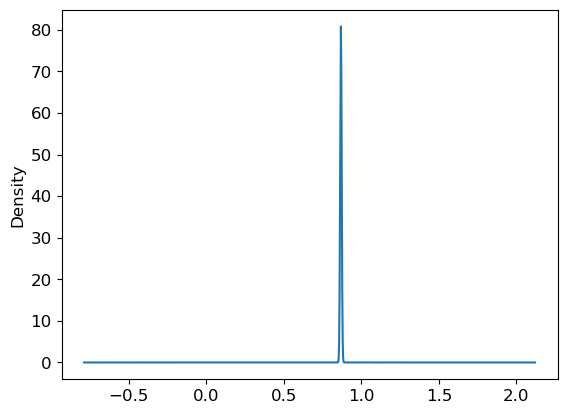

In [66]:
sc_data['mavedb.score'].plot(kind='kde')


<Axes: xlabel='DITTO', ylabel='mavedb.score'>

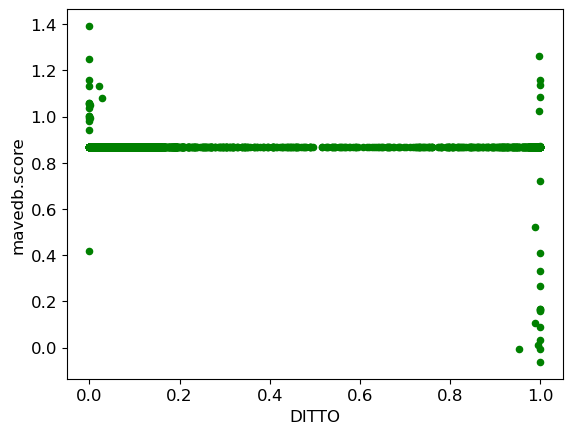

In [65]:
sc_data.plot(kind='scatter', x='DITTO', y='mavedb.score', color='g')
